In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns

import glob, os, time, datetime, mlflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import relu, softmax

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.metrics import classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from IPython.display import Image, display

In [3]:
len(tf.config.experimental.list_physical_devices('GPU'))

0

In [5]:
tf.__version__

'2.16.1'

In [6]:
# Increasing the size of the figure a bit
plt.rcParams.update({'figure.figsize': (12, 7)}) 

# CNN classification of chest X-Ray Images

## Implementing CNN classification and visualization with Tensorflow 2.7

## Summary

The main purpose of thisproject is to get familiar with main Deep Learning concepts. Throughout the notebook I will be working with several models on a [chest x-ray dataset found on kaggle](https://www.kaggle.com/jtiptj/chest-xray-pneumoniacovid19tuberculosis) containing four calsses of images - <b>Covid19, Normal, Pneumoniaand, Turberculosis</b>. I wanted to experiment a bit with a less common classification task which is what attracted me to x-ray images. This dataset combines four different ones (that can also be found on kaggle) which seemed appealing as my main worry was that I might not have enough data to properly train a neural network.

## Introduction

I begin by setting up and tuning my own custom model from scratch and training it on the dataset. Afterwards I use MobileNetv3-Small for a transfer learning approach to the same calssification task. All I have at my disposal is a CPU and with MobileNet being a very efficient algorythm, it seemed like the obvious choice. 

## 1. Exploring and reading the dataset

In [11]:
# Placing all dataset directories in a dictionary to keep things neat
datasets = {
    "xray_train": "../data/Chest X-Rays/train",
    "xray_test": "../data/Chest X-Rays/test",
    "xray_val": "../data/Chest X-Rays/val"
}

# Datasets summary
for dataset in datasets:
    print(dataset + ":", len(glob.glob(datasets[dataset] + '/*/*')))

xray_train: 6326
xray_test: 771
xray_val: 38


Right off the bat I can see that the data I have at my disposal is not all that much. The validation split is quite small so I will only be utilizing it for evaluation of the models. The test set will be what I am passing to the model's for validation during training as that set should have a lot more varied images and shuld prove more reliable.

In [13]:
# # Google Colab setup

# from google.colab import drive

# drive.mount('/content/drive')

# datasets = {
#     "xray_train": "/content/drive/MyDrive/Colab Notebooks/data/Chest X-Rays/train",
#     "xray_test": "/content/drive/MyDrive/Colab Notebooks/data/Chest X-Rays/test",
#     "xray_val": "/content/drive/MyDrive/Colab Notebooks/data/Chest X-Rays/val"
# }
# for dataset in datasets:
#     print(dataset + ":", len(glob.glob(datasets[dataset] + '/*/*')))

Setting up a dictionary with all classes and their ids for classification

In [19]:
xray_class_names = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2,
    'TURBERCULOSIS': 3,
}

### 1.1 Class distributions

Let's take a look at the class distributions for each of the three sets.

Train Images
460 - COVID19
1341 - NORMAL
3875 - PNEUMONIA
650 - TURBERCULOSIS


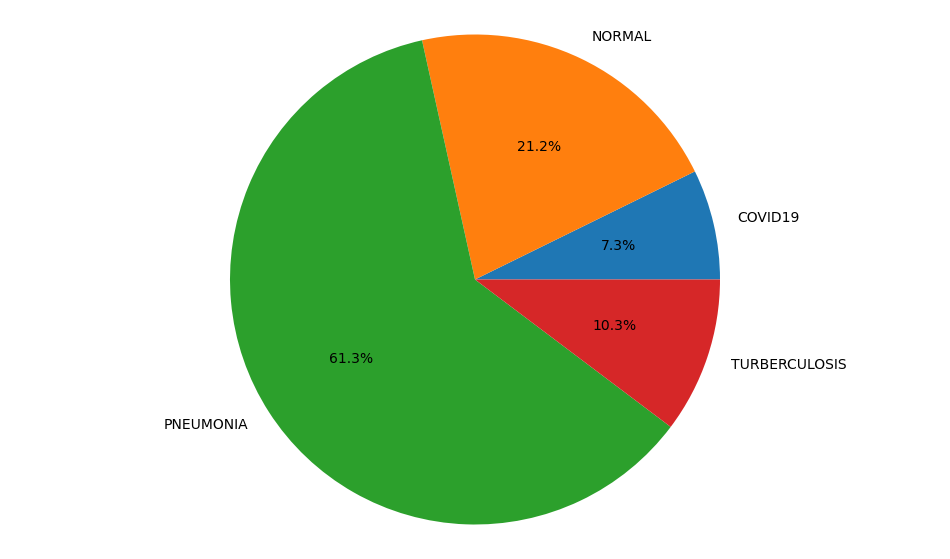

In [24]:
# Counting test observations per class
xray_observations_train = []
for i, path in enumerate(glob.glob(datasets["xray_train"] + '/*')):
    xray_observations_train.append(len(glob.glob(path + "/*")))

# Printing the results
print("Train Images")
for i in xray_class_names.values():
    print(xray_observations_train[i],"-",list(xray_class_names)[i])

# Class distribution pie plot
plt.pie(xray_observations_train,
        explode=(0, 0, 0, 0), 
        labels=xray_class_names,
        autopct='%1.1f%%')
plt.axis('equal')
#plt.title(str(i))
plt.show()

The training data is quite heavily imbalanced which might prove problematic. I will definitely need to look into ways of dealing with the class imbalance.


Test Images
106 - COVID19
234 - NORMAL
390 - PNEUMONIA
41 - TURBERCULOSIS


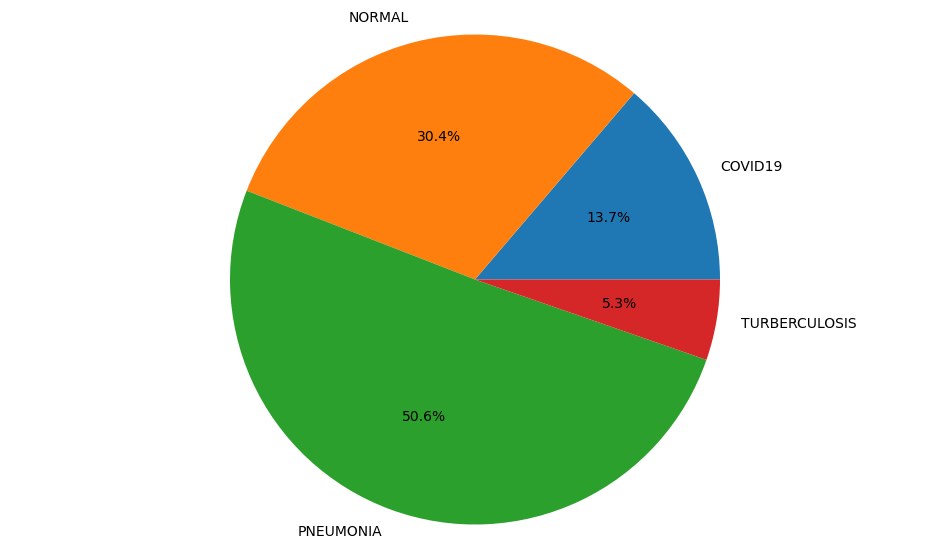

In [27]:
# Counting test observations per class
xray_observations_test = []
for i, path in enumerate(glob.glob(datasets["xray_test"] + '/*')):
    xray_observations_test.append(len(glob.glob(path + "/*")))

# Printing the results
print("\nTest Images")
for i in xray_class_names.values():
    print(xray_observations_test[i],"-",list(xray_class_names)[i])

# Class distribution pie plot
plt.pie(xray_observations_test,
        explode=(0, 0, 0, 0), 
        labels=xray_class_names,
        autopct='%1.1f%%')
plt.axis('equal')
#plt.title(str(i))
plt.show()

Test set has almost the same distribution as the train data. Ideally I'd like there to be identical number of test observations for each class but with the current data that would leave me either with too few images for the test split or reduce the train set which is already quite small so I will continue without altering the sets.


Val Images
10 - COVID19
8 - NORMAL
8 - PNEUMONIA
12 - TURBERCULOSIS


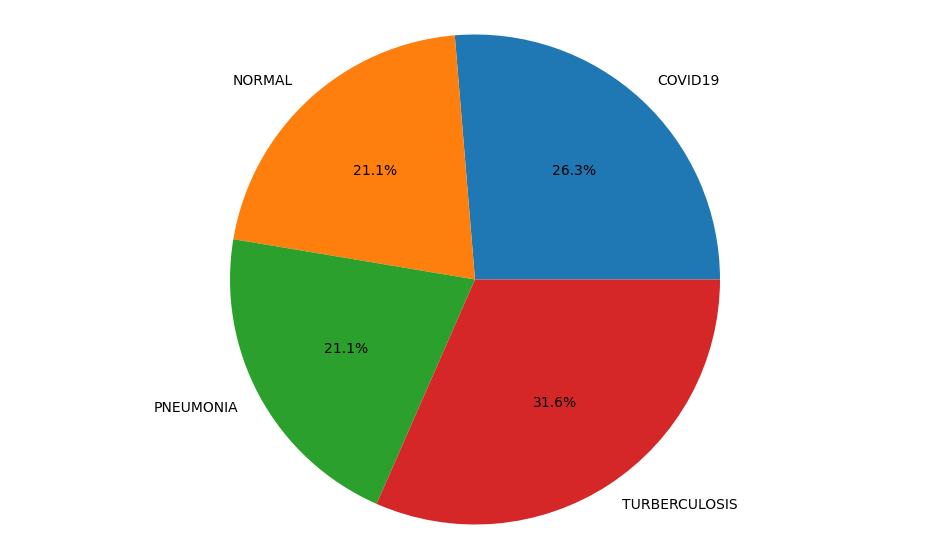

In [30]:
# Counting val observations per class
xray_observations_val = []
for i, path in enumerate(glob.glob(datasets["xray_val"] + '/*')):
    xray_observations_val.append(len(glob.glob(path + "/*")))
    
# Printing the results
print("\nVal Images")
for i in xray_class_names.values():
    print(xray_observations_val[i],"-",list(xray_class_names)[i])

# Class distribution pie plot
plt.pie(xray_observations_val,
        explode=(0, 0, 0, 0), 
        labels=xray_class_names,
        autopct='%1.1f%%')
plt.axis('equal')
#plt.title(str(i))
plt.show()

As we already saw, very few val observations but should be useable for evaluating trained models.

### 1.2 Loading the dataset
I will set up a data load function which will utilize Keras' ImageDataGenerator.

Let's start by hard coding some values:

In [34]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

Since I only have a CPU at my disposal I would benefit from a smaller IMAGE_SIZE but cinsidering the task I have set for myself I cannot go too low resolution as the illnesses can be a very small part of the entire image and the lower I go the less data there will be for the networks to work with.

Next I will set up the data generating function. To assist with the lack of data and to better improve the networks' ability to generalize I will also use some data augmentation. X-ray images are usually scanned and they can vary in width, height, orientation, aspect ratio and so on and the augmentations should help with all of that. 

ImageDataGenerator also lets me scale the data which I will take advantage of as well.

Last adjustment I would like to make is to grayscale the images. I did notice that some of the Covid xrays have a blue tint and a very large portion of the Turberculosis ones are purple. I do not want the networks to use the color of the images as a crutch.

In [38]:
def generate_data(IMAGE_SIZE, BATCH_SIZE, train_dir, test_dir, val_dir, train_augmentation=0):


    if train_augmentation:
        # Data augmentation + data generator
        train_datagen = ImageDataGenerator(rescale=1./255,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           rotation_range=8,
                                           horizontal_flip=True
                                          )
    else:
        # Data generator
        train_datagen = ImageDataGenerator(rescale=1./255)

    # No augmentation applied to the test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generating
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='sparse',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
        ,color_mode = 'grayscale',
        # class_mode='categorical',
        class_mode='sparse',
        shuffle=False
    )

    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        color_mode = 'grayscale',
        # class_mode='categorical',
        class_mode='sparse',
        shuffle=False
    )
    
    print ("Each image is of size: {}".format(IMAGE_SIZE))
    
    return train_generator, test_generator, val_generator

In [40]:
train_generator, test_generator, val_generator = generate_data(IMAGE_SIZE, BATCH_SIZE, datasets["xray_train"], datasets["xray_test"], datasets["xray_val"])

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Each image is of size: (224, 224)


### 1.3 Viewing the data

Let's have a look at some examples from the train set.

In [43]:
def show_images(from_index, to_index, xray_class_names, train_images, train_labels):
    # 20 random images from the train set
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("Some examples of the dataset images", fontsize=16)

    #index = np.random.randint(train_images.shape[0]) 
    plot_spot = 0
    for i in range(from_index, to_index):  
        plt.subplot(5,5,plot_spot+1)
        plot_spot+=1
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
        plt.xlabel(list(xray_class_names)[train_labels[i]])
    plt.show()

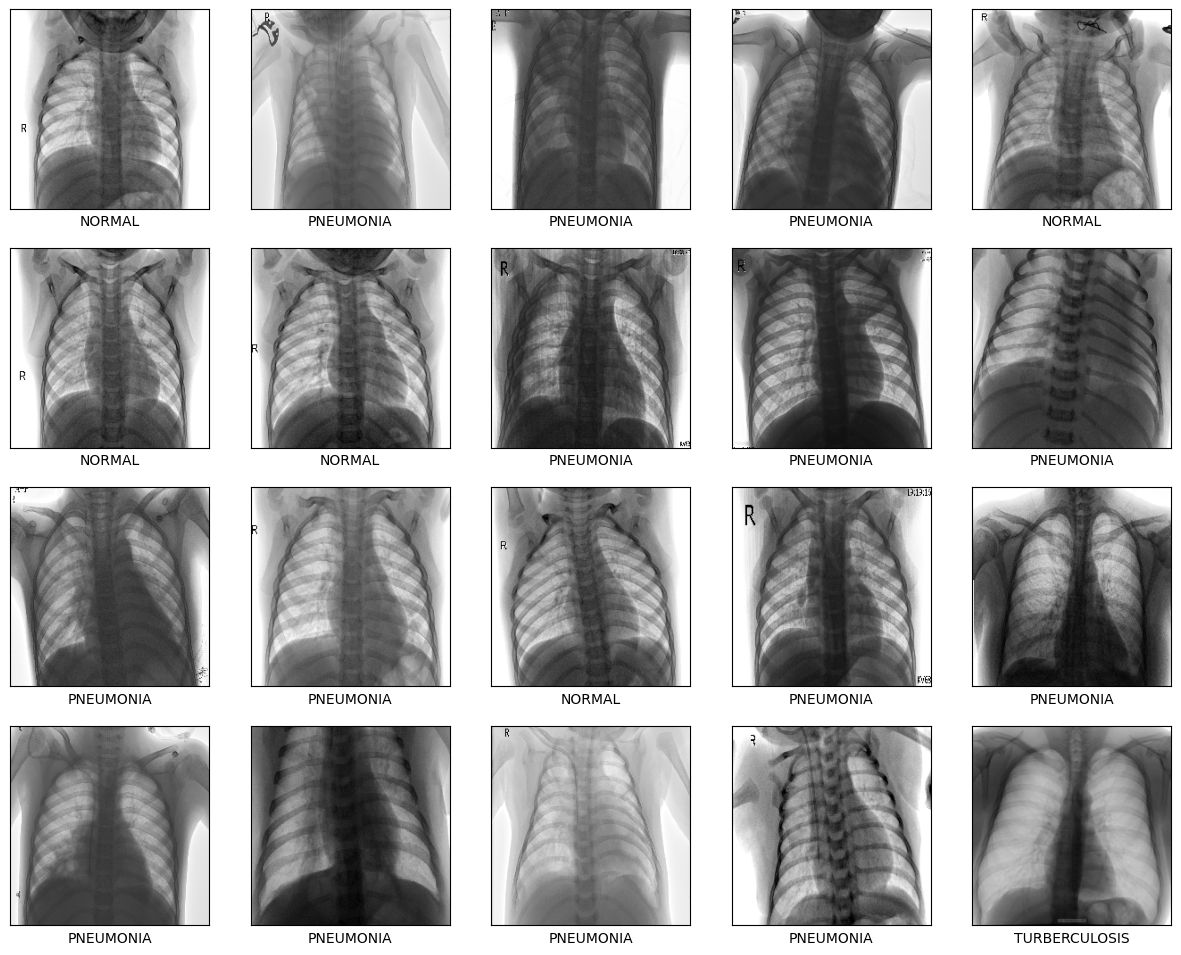

In [45]:
# 20 random images from the train set

train_batch = next(train_generator)
index = np.random.randint(train_batch[0].shape[0]-10) 

show_images(index-10, index+10, xray_class_names, train_batch[0], np.int32(train_batch[1]))

## 2. Metrics, callbacks and other functions
Let's set up some function which I can use for each of the models I work with.

### 2.1 Metrics
Setting up the metric function for model evaluation:

- plot_accuracy_loss - plotting the accuracy and loss history is quite important to monitor a model's training;
- plot_confusion_matrix - I find confusion matrixes very useful for evaluating calssification models especially for imbalanced classification tasks as this one;
- show_classification_report - unfortunately I am having to import classification_report from sklearn which may be an unnecessary dependancy for just a single metric but I do like having it avilable;

In [49]:
# Accuracy and loss training plots per epoch
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(15,9))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'o-', label = "train")
    plt.plot(history.history['val_accuracy'], 'o-', label = "val")
    plt.title("train vs val accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'o-', label = "train")
    plt.plot(history.history['val_loss'], 'o-', label = "val")
    plt.title("train vs val loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
# Confusion matrix plot
def plot_confusion_matrix(model, generator):
    
    predictions = model.predict(generator, batch_size=BATCH_SIZE)
    predictions_lables = [np.argmax(i) for i in predictions]

    cf_matrix = tf.math.confusion_matrix(generator.classes, predictions_lables)

    ax = plt.axes()
    plt.xticks(fontsize= 16)
    plt.yticks(fontsize = 16)
    sns.heatmap(cf_matrix, 
                annot=True, 
                linewidths=2, 
                cmap='Blues', 
                annot_kws={"size": 15}, 
                xticklabels=xray_class_names, 
                yticklabels=xray_class_names, 
                ax = ax)
    plt.show()
    
# Classification report function
def show_classification_report(model, generator):
    
    predictions = model.predict(generator)
    test_filenames = generator.filenames
    y_true = generator.classes
    y_pred = predictions.argmax(axis=1)
    
    cm_plot_labels = ['Covid', 'Normal', 'Pneumonia', 'Tuberculosis']
    
    print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

### 2.2 Callbacks

- TensorBorad - quite useful for model comparisons;
- ModelCheckpoint - amazing for retrieving the best performing epoch of a model;
- EarlyStopping - convenient for when you have limited resources and a general time saver;
- ReduceLROnPlateau - great for squeezing out the last it of accuracy out of a model;

I want both Checkpoint and TensorBoard to be able to take in different directories for my own convenience.

In [52]:
# General purpose datetime tag
def timing():
    timing = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return timing

# Tensorboard callback with customizable directory
def tb_cb(tb_dir):
    tensor_board_cb = TensorBoard(
#         log_dir=f"./TensorBoard/{model_name}/{model_name}-{timing}", 
        tb_dir,
        profile_batch=0)
    return tensor_board_cb

# Checkpoint callback with customizable directory
def acc_cp_cb(cp_dir):
    accuracy_checkpoint_cb = ModelCheckpoint(
        cp_dir,
        monitor='val_accuracy', 
        mode='max', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False)
    return accuracy_checkpoint_cb

# Early stopping callback
es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=7,
    min_delta=0.0001, 
    restore_best_weights=True)

# Learning rate callback
lr_plateau_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=3,
    mi_delta=0.0001)

### 2.3 MLFlow

Let's also set up an MLFlow tracking function so that I can monitor the various model architectures. I want this to be able to take a model.fit() function and have it track everything (mainly because it's the least time consuming option for me currently).

In [55]:
def mlflow_tracking(model_name, model_history, LEARNING_RATE, BETA_1, EPOCHS):
    
    mlflow.tensorflow.autolog()
    mlflow.set_experiment(experiment_name = model_name)
    experiment_id = mlflow.get_experiment_by_name(model_name).experiment_id

    with mlflow.start_run(experiment_id = experiment_id) as run:
        experiment_id = mlflow.get_experiment_by_name(model_name).experiment_id
#         print(experiment_id)
        run_id = mlflow.active_run().info.run_id
#         print(run_id)
        timings = "{}-{}".format(experiment_id, run_id)
#         print(timings)
        
        if LEARNING_RATE != None and BETA_1 != None and EPOCHS != None:
        
            history = model_history(timings, LEARNING_RATE, BETA_1, EPOCHS)
#             print("Learning rate: "+str(LEARNING_RATE))
#             print("beta_1: "+str(BETA_1))
#             print("epochs: "+str(EPOCHS))
        else:
            history = model_history(timings, LEARNING_RATE=None, BETA_1=None, EPOCHS=None)
#             print("Learning rate: "+str(LEARNING_RATE))
#             print("beta_1: "+str(BETA_1))
#             print("epochs: "+str(EPOCHS))
        
    mlflow.tensorflow.autolog(disable=True)
    return history

### 2.4 Class Weights dict
 I will set up a class_weights disctionary I can pass to the models to try and eliviate the imbalance issue.

In [58]:
from sklearn.utils import class_weight


# class_weights = class_weight.compute_class_weight(
#     'balanced', 
#     np.unique(train_generator.classes), 
#     train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))

class_weights = {0:8.4, 1:2.9, 2:1, 3:6} # Manual calculation

## 3. Setting up and training custom Convolutional Neural Networks from scratch

### 3.1 Basic CNN
Let's start by setting up a simple CNN to get a sense of the task ahead of me. No augmented data for this one yet as i want to have an idea of what I am dealing with.

Both the model and it's training will have separate functions which will make things a bit more orderly and easy for me to use and track using MLFLOW, Tensorboard and Checkpoint.

For the model I will do a few convolutional layers with MaxPool2D in between to reduce my training time as much as possible, some feature selection, and also have the model focus on the details of the image. BatchNorms are also quite usefult to keep things efficient by not letting the activations get too large. Some Dropout for the Dense calssification layers will also help with the model's ability to generalize a bit better.

In [63]:
def cnn_basic():    
    CNN_basic = Sequential([

        Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),

    #         Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = relu), 
        Conv2D(filters = 8, kernel_size = 5, padding = "same", activation = relu),
        #BatchNormalization(), # Scaling for activation function parameters
        MaxPool2D(2,2), # Combines 2x2 in this case grid and keeps the highest activation out of the 4. Feature selection and dimentionality reduction

        Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = relu),
        #BatchNormalization(),
        MaxPool2D(2,2),

        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = relu),
        BatchNormalization(),
        MaxPool2D(2,2),


        Flatten(),
        #Dropout(0.2),   # Equivalent to feature selection as it removes features before they are run trough the model
        #BatchNormalization(),

        Dense(64, activation = relu),
        Dropout(0.25),

        Dense(4, activation = softmax)
    ])
    
    return CNN_basic

CNN_basic = cnn_basic()
CNN_basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,612,100 (6.15 MB)

 Trainable params: 1,612,036 (6.15 MB)

 Non-trainable params: 64 (256.00 B)

For the training I will be using the Adam optimizer as it is the safe and obvious choice with the sparse categorical crossentropy loss function.

I want to play around with the learning rate and beta_1 params a bit as well which is why I'll set up the function in such a way that it can take in different values for both of these parameters.

In [66]:
# Setting up a function for the model.fit and model.compile with customizable hparams

def cnn_basic_tuning(details=None, LEARNING_RATE=None, BETA_1=None, EPOCHS=None):
    
    # Optional lr and beta_1 inputs
    if LEARNING_RATE != None and BETA_1 != None and EPOCHS != None:
        LEARNING_RATE = LEARNING_RATE
        BETA_1 = BETA_1
        EPOCHS = EPOCHS
    else:
        # For manual use
        LEARNING_RATE = 1e-7
        BETA_1 = 0.95
        EPOCHS = 2
        
    print("Learning rate: "+str(LEARNING_RATE))
    print("beta_1: "+str(BETA_1))
    print("epochs: "+str(EPOCHS))
        
    # Compile model
    CNN_basic.compile(optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1), 
                  loss = SparseCategoricalCrossentropy(),
                  weighted_metrics=['accuracy'],
                  metrics=['accuracy'])
    
    # I want to be able to use this function with or without tracking from MLFlow
    if details:
        details = details       
    else:
        details = timing()
        
#     print("I am inside the history now")
#     print(details)
        
    history = CNN_basic.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            steps_per_epoch=len(train_generator.classes) // BATCH_SIZE,
                            validation_data = test_generator,
                            shuffle=True,
#                             class_weight=class_weights,
                            callbacks = [
                                acc_cp_cb("./Checkpoints/CNN_basic/CNN_basic-{val_accuracy:.2f}-{epoch:02d}"+f"-{details}.keras"),
                                tb_cb(f"./TensorBoard/CNN_basic/CNN_basic-{details}"),
                                es_cb,
                                lr_plateau_cb])
    return history

Since I don't expect to have enough time to test every possible parameter combination I will mostly be relying on manual architecture nad hyper parameter searching as well as the occasional semi-random search as well.

The below cell is used for manual searches.

In [69]:
# # This cell is just here for manual searches

# mlflow.tensorflow.autolog(disable=True) # When I am loggin I will be doing it using the below cell

# mlflow.tensorflow.autolog(disable=True)
# # tf.keras.backend.clear_session()
# CNN_basic = cnn_basic()

# # cnn_history = cnn_basic_tuning(details = None, LEARNING_RATE = i, BETA_1 = j, EPOCHS = k)
# CNN_basic_history = cnn_basic_tuning(details = None, LEARNING_RATE = 1e-4, BETA_1 = 0.95, EPOCHS = 5)

I have this next cell set up in such a way that I can do semi-random hyper parameter searches by passing in the values I want and letting it run. All of the results will be tracked and I can review everything in MLFlow and Tensorboard afterwards.

In [48]:
# mlflow.create_experiment(name = 'CNN_basic') # id 0

In [49]:
# Semi-random hparam searching and tracking
for LEARNING_RATE, BETA_1, EPOCHS in [
#     [1e-3, 0.90, 4], [1e-4, 0.90, 4], [1e-5, 0.90, 4], 
#     [1e-3, 0.95, 4], [1e-4, 0.95, 4], [1e-5, 0.95, 4],
#     [1e-3, 0.99, 4], [1e-4, 0.99, 4], [1e-5, 0.99, 4]
    [1e-4, 0.95, 30]
]:
    
    # Resetting model and clearing session between each run
    tf.keras.backend.clear_session()
    CNN_basic = cnn_basic()
    
    # MLFlow tracking function running the CNN_Basec tuning/training function
    CNN_basic_history = mlflow_tracking(
        model_name = "CNN_basic", 
        model_history = cnn_basic_tuning, 
        LEARNING_RATE = LEARNING_RATE, 
        BETA_1 = BETA_1, 
        EPOCHS = EPOCHS)

Traceback (most recent call last):
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksb

Learning rate: 0.0001
beta_1: 0.95
epochs: 30


2024/06/08 01:15:14 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/06/08 01:15:14 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/30


C:\Users\ksbon\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7853 - loss: 0.5549 - weighted_accuracy: 0.7853
Epoch 1: val_accuracy improved from -inf to 0.85084, saving model to ./Checkpoints/CNN_basic/CNN_basic-0.85-01-952439663771619896-fe6a8c2392b2423abfc5a0aaf8f7da40.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 702ms/step - accuracy: 0.7862 - loss: 0.5528 - weighted_accuracy: 0.7862 - val_accuracy: 0.8508 - val_loss: 1.1171 - val_weighted_accuracy: 0.8508 - learning_rate: 1.0000e-04
Epoch 2/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.9531 - loss: 0.1568 - weighted_accuracy: 0.9531

C:\Users\ksbon\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.85084 to 0.85214, saving model to ./Checkpoints/CNN_basic/CNN_basic-0.85-02-952439663771619896-fe6a8c2392b2423abfc5a0aaf8f7da40.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9531 - loss: 0.1568 - weighted_accuracy: 0.9531 - val_accuracy: 0.8521 - val_loss: 1.1135 - val_weighted_accuracy: 0.8521 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9489 - loss: 0.1429 - weighted_accuracy: 0.9489
Epoch 3: val_accuracy did not improve from 0.85214


98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 639ms/step - accuracy: 0.9489 - loss: 0.1427 - weighted_accuracy: 0.9489 - val_accuracy: 0.8418 - val_loss: 0.9400 - val_weighted_accuracy: 0.8418 - learning_rate: 1.0000e-04
Epoch 4/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.9219 - loss: 0.1849 - weighted_accuracy: 0.9219
Epoch 4: val_accuracy did not improve from 0.85214


98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9219 - loss: 0.1849 - weighted_accuracy: 0.9219 - val_accuracy: 0.8275 - val_loss: 0.9371 - val_weighted_accuracy: 0.8275 - learning_rate: 1.0000e-04
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9725 - loss: 0.0802 - weighted_accuracy: 0.9725
Epoch 5: val_accuracy did not improve from 0.85214


98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 638ms/step - accuracy: 0.9725 - loss: 0.0802 - weighted_accuracy: 0.9725 - val_accuracy: 0.7808 - val_loss: 0.7169 - val_weighted_accuracy: 0.7808 - learning_rate: 1.0000e-04
Epoch 6/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9444 - loss: 0.1100 - weighted_accuracy: 0.9444
Epoch 6: val_accuracy did not improve from 0.85214


98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9444 - loss: 0.1100 - weighted_accuracy: 0.9444 - val_accuracy: 0.7899 - val_loss: 0.7106 - val_weighted_accuracy: 0.7899 - learning_rate: 1.0000e-04
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9812 - loss: 0.0600 - weighted_accuracy: 0.9812
Epoch 7: val_accuracy did not improve from 0.85214


98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 627ms/step - accuracy: 0.9812 - loss: 0.0600 - weighted_accuracy: 0.9812 - val_accuracy: 0.8392 - val_loss: 0.4856 - val_weighted_accuracy: 0.8392 - learning_rate: 1.0000e-04
Epoch 8/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9688 - loss: 0.1009 - weighted_accuracy: 0.9688
Epoch 8: val_accuracy did not improve from 0.85214
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9688 - loss: 0.1009 - weighted_accuracy: 0.9688 - val_accuracy: 0.8353 - val_loss: 0.4963 - val_weighted_accuracy: 0.8353 - learning_rate: 1.0000e-04
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9843 - loss: 0.0506 - weighted_accuracy: 0.9843
Epoch 9: val_accuracy did not improve from 0.85214
98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 645ms/step - accuracy: 0.9843 - loss: 0.0505 - weighted_accuracy: 0.9843 - val_accuracy: 0.7964 - val_loss: 0.5705 - val_weighted_accuracy: 0.7964 - learning_rate: 1.0000e-04
Epoch 10/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step

98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 1.0000 - loss: 0.0108 - weighted_accuracy: 1.0000 - val_accuracy: 0.7964 - val_loss: 0.5599 - val_weighted_accuracy: 0.7964 - learning_rate: 1.0000e-04
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9945 - loss: 0.0250 - weighted_accuracy: 0.9945
Epoch 11: val_accuracy did not improve from 0.85214
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 617ms/step - accuracy: 0.9945 - loss: 0.0251 - weighted_accuracy: 0.9945 - val_accuracy: 0.7873 - val_loss: 0.7303 - val_weighted_accuracy: 0.7873 - learning_rate: 1.0000e-05
Epoch 12/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9688 - loss: 0.0397 - weighted_accuracy: 0.9688
Epoch 12: val_accuracy did not improve from 0.85214
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9688 - loss: 0.0397 - weighted_accuracy: 0.9688 - val_accuracy: 0.7860 - val_loss: 0.7384 - val_weighted_accuracy: 0.7860 - learning_rate: 1.0000e-05
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/ste

2024/06/08 01:23:50 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/06/08 01:23:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/06/08 01:24:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ksbon\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils."


### CNN_basic model evaluation

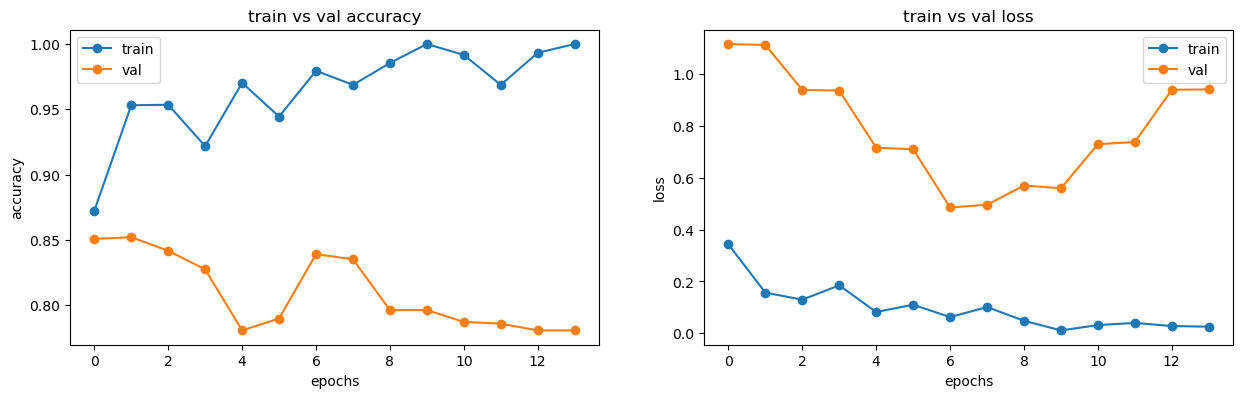

In [51]:
# Plotting the model training curves
plot_accuracy_loss(CNN_basic_history)

Both the loss and val functions can be quite bouncy on the validation data but on the train data they are quite stable. That indicated that I have an overfitting problem even with this simple model. The data augmentation is definitely needed. 

The unstable nature is also telling me that I should lower the learning rate a bit to try and counter this behaviour. 

There is also a very significant gap between the training and val accuracy so some more regularization will be required.

The below model is the best perfoeming version of CNN_basic I managed to train so will use it for the evaluation.

In [72]:
# Loading the best performing model
# CNN_basic_loaded = tf.keras.models.load_model("./mlruns/0/2854197c8ac64b65a1a34d45fe2295d8/artifacts/model/data/model")
# CNN_basic_loaded = tf.keras.models.load_model("./mlruns/0/CNN_basic-0.87-01-0-2854197c8ac64b65a1a34d45fe2295d8.h5")
# CNN_basic_loaded.evaluate(test_generator)

In [74]:
# plot_confusion_matrix(CNN_basic, test_generator)
# plot_confusion_matrix(CNN_basic_loaded, test_generator)

From the confusion matrix we can see that the model is struggeling mainly with Pneumonia images that get calssified as Normal instead. Since the dataset is 61% Pneumonia xrays, it is not a huge surprise that the main issue revolves around  missclassification of Pneumonia.

The normal images are the ones getting the highest number of errors so the class separation between those and the Pneumonia ones is probably not that pronounced. 

The other two are doing fairly well at least for this basic model.

In [77]:
# Test data clssification report
# show_classification_report(CNN_basic, test_generator)
# show_classification_report(CNN_basic_loaded, test_generator)

The classification report gives some numerical values to what we saw in the confusion matrix. The model is correctly classifying 93% of the normal images but also missclassifiyng quite a large portion of the Pneumonia ones as normal as well. 

In [80]:
# CNN_basic_loaded.evaluate(val_generator)

Very good results on the val set so it does seem that the images are easier to differentiate than the test set.

## 3.2 Expanded Convolutional Neural Network

The first model has showcased several issues. I will now try to expand it and address each one.

### 3.2.1 Augmented training data
By utilizing the augmented data I will increase the model's train time quite a bit but it would also supply it with more data to work with which will hopefully improve its performance.

No augmentations will be applied to the test and val sets (other than scaling) as I do not want to interfere with the scores in any way.

In [64]:
train_generator_augmented, test_generator, val_generator = generate_data(
    IMAGE_SIZE, BATCH_SIZE, datasets["xray_train"], datasets["xray_test"], datasets["xray_val"], 1)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Each image is of size: (224, 224)


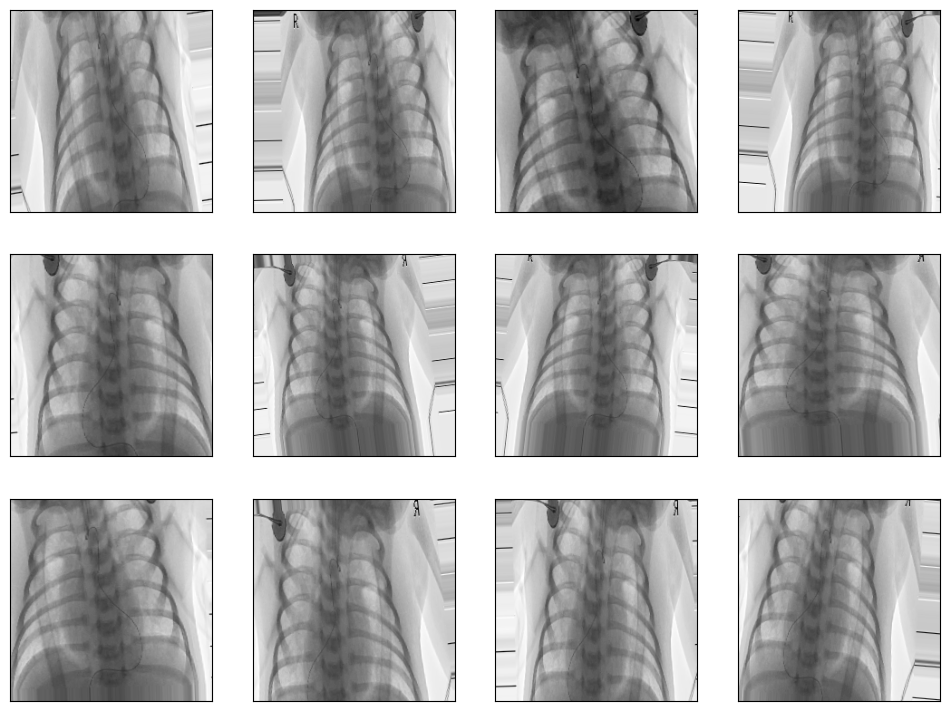

In [65]:
# Example of 20 augmented image variations
augmented_batch_index = np.random.randint(32)
augmented_images = [train_generator_augmented[0][0][augmented_batch_index] for i in range(12)]

plt.figure(figsize=(12,9))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_images[i], cmap=plt.cm.binary)
plt.show()

### 3.2.2 Keras Tuner for hyper parameter tuning
I want to experiment with different model architecture setups and KerasTuner allows me to do so quite easily. Its RandomSearch function will let me look trought a few values whenever I have time and then summaryze the best ones. It also provides another way of optimizing hyperparameters.

In [89]:
# # Wish I had a GPU or 10

# def build_model(hp):
#     model = Sequential()
    
#     model.add(Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))

#     # Convolutional layers 
    
# #     for i in range(hp.Int("n_layers_Conv2D", 1, 4)):
# #         model.add(Conv2D(filters = hp.Choice('filters',values = [8, 16, 32, 64, 96, 128]), 
# #                          kernel_size=(3,3), padding="same", activation=relu))
# #          model.add(BatchNormalization())
# #          model.add(MaxPool2D(2,2))

# #     model.add(Conv2D(filters = hp.Choice('Conv2D 1',values = [8, 16, 32, 64]), 
# #                      kernel_size=(3,3), padding="same", activation=relu))
#     model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation=relu))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(2,2))
    
#     model.add(Conv2D(filters = hp.Choice('Conv2D 2',values = [16, 32, 64]), 
#                      kernel_size=(3,3), padding="same", activation=relu))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(2,2))
    
#     model.add(Conv2D(filters = hp.Choice('Conv2D 3',values = [16, 32, 64]),
#                      kernel_size=(3,3), padding="same", activation=relu))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(2,2))
    
#     model.add(Conv2D(filters = hp.Choice('Conv2D 4',values = [32, 64, 128]),
#                      kernel_size=(3,3), padding="same", activation=relu))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(2,2))
    
#     model.add(Conv2D(filters = hp.Choice('Conv2D 4',values = [64, 128, 256]),
#                      kernel_size=(3,3), padding="same", activation=relu))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(2,2))
        
# #     model.add(BatchNormalization())   # Scaling for activation function parameters
# #     model.add(MaxPool2D(2,2))    # Combines 2x2 in this case grid and keeps the highest activation out of the 4. Feature selection and dimentionality reduction
        
#     model.add(Flatten())

#     # Dense layers
    
# #     for i in range(hp.Int("n_layers_Dense", 1, 4)):
# #         model.add(Dense(hp.Choice('units', values=[8, 16, 32, 64, 96, 128, 256]), activation=relu),)
# #         model.add(Dropout(hp.Choice('Dropout1', values=[0.1, 0.2, 0.3, 0.5, 0.7])))

#     model.add(Dense(hp.Choice('Dense 1', values=[64, 128, 256, 512]), activation=relu))
#     model.add(Dropout(hp.Choice('Dropout 1', values=[0.1, 0.2, 0.5])))
    
#     model.add(Dense(hp.Choice('Dense 2', values=[64, 128, 256]), activation=relu))
#     model.add(Dropout(0.2)) 
    
#     model.add(Dense(hp.Choice('Dense 3', values=[32, 64, 128]), activation=relu))
#     #model.add(Dropout(0.1)) 
    
#     model.add(Dense(4, activation=softmax))
    
    
#     # Compile
#     model.compile(optimizer = Adam(learning_rate=hp.Choice("learning rate", values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])), 
#                   #beta_1 = hp.Choice("beta 1", values=[0.9, 0.95, 0.99]),
#                   beta_1 = 0.95,
#                   loss = SparseCategoricalCrossentropy(), 
#                   metrics=['accuracy'])              
#     return model

The model architecture was mostly determined by trial and error and what I am mostly looking for in this search is the optimal learning rate, beta_1 and Droupout values. I also want to test the kernel size of my starting conv layers as I am unsure if I want to go with 5 or 3.

In [91]:
# KerasTuner model
def cnn_expanded_tuner_model(hp):
    model = Sequential()
    
    model.add(Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))

    # Convolutional layers
    
    model.add(Conv2D(filters = 32, kernel_size = hp.Choice('Conv2D 1 kernel', values=[3,5]), padding="same", activation=relu))
#     model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))

    model.add(Conv2D(filters = 32, kernel_size = hp.Choice('Conv2D 2 kernel', values=[3,5]), padding="same", activation=relu))
#     model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding="same", activation=relu))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation=relu))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding="same", activation=relu))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
                
    model.add(Flatten())

    # Dense layers
    
    model.add(Dense(512, activation=relu))
    model.add(Dropout(hp.Choice('Dropout 1', values=[0.0001, 0.25, 0.5])))
    
    model.add(Dense(256, activation=relu))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(128, activation=relu))
    model.add(Dropout(0.1)) 
    
    model.add(Dense(4, activation=softmax))
    
    
    # Compile
    model.compile(optimizer = Adam(learning_rate=hp.Choice("learning rate", values=[1e-3, 1e-4, 1e-5, 1e-8]), 
                                   beta_1 = hp.Choice("beta 1", values=[0.9, 0.95, 0.99])), 
                  loss = SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])   
    
    return model

In [65]:
# Setting up the tuner object
CNN_expanded_tuner = RandomSearch(
    cnn_expanded_tuner_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='./KerasTuner',
    project_name='CNN_expanded'
)

In [67]:
# Search parameters summary
CNN_expanded_tuner.search_space_summary()

Search space summary
Default search space size: 5
Conv2D 1 kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
Conv2D 2 kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
Dropout 1 (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.25, 0.5], 'ordered': True}
learning rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-08], 'ordered': True}
beta 1 (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.95, 0.99], 'ordered': True}


In [69]:
# Tuner training and searching
CNN_expanded_tuner.search(train_generator_augmented,
                          validation_data=test_generator,
                          epochs=8,
                          batch_size=BATCH_SIZE,
                          steps_per_epoch=len(train_generator.classes) // BATCH_SIZE,
                          callbacks=[
                              acc_cp_cb("./Checkpoints/CNN_expanded_tuner/CNN_expanded_tuner-{val_accuracy:.2f}-{epoch:02d}.keras"),
                              tb_cb("./TensorBoard/CNN_expanded_tuner"),
                          ])

Trial 1 Complete [00h 08m 37s]
val_accuracy: 0.6199740767478943

Best val_accuracy So Far: 0.6199740767478943
Total elapsed time: 00h 08m 37s


In [70]:
# Best results from the search
CNN_expanded_tuner.get_best_hyperparameters()[0].values

{'Conv2D 1 kernel': 5,
 'Conv2D 2 kernel': 5,
 'Dropout 1': 0.5,
 'learning rate': 0.0001,
 'beta 1': 0.95}

In [71]:
# Results summary
# CNN_expanded_tuner.results_summary()

In [72]:
# Best KeraTuner model
print(CNN_expanded_tuner.get_best_models()[0].summary())

C:\Users\ksbon\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │              

 Total params: 3,505,476 (13.37 MB)

 Trainable params: 3,505,028 (13.37 MB)

 Non-trainable params: 448 (1.75 KB)

None


### 3.2.3 Expanded Convolutional Neural Network
Building out the best model from KerasTuner

In [95]:
def cnn_expanded():

    CNN_expanded = Sequential([    

        Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),

        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = relu),
#         BatchNormalization(),
        MaxPool2D(2,2),

        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = relu),
#         BatchNormalization(),
        MaxPool2D(2,2),

        Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = relu), 
        BatchNormalization(),
        MaxPool2D(2,2),

        Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = relu),
        BatchNormalization(),    
        MaxPool2D(2,2),

        Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = relu),
        BatchNormalization(),
        MaxPool2D(2,2),

        Flatten(),    
#         Dropout(0.2),
#         BatchNormalization(), 

        Dense(512, activation='relu'),    
#         Dropout(0.3),

        Dense(256, activation='relu'),    
        Dropout(0.25),

        Dense(128, activation='relu'),    
        Dropout(0.15),

        Dense(4, activation='softmax')
    ])
    return CNN_expanded

CNN_expanded = cnn_expanded()
CNN_expanded.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             5

 Total params: 3,488,580 (13.31 MB)

 Trainable params: 3,488,132 (13.31 MB)

 Non-trainable params: 448 (1.75 KB)

In [97]:
# Setting up a function for the model.fit and model.compile with customizable hparams

def cnn_expanded_tuning(details=None, LEARNING_RATE=None, BETA_1=None, EPOCHS=None):
    
    # Optional lr and beta_1 inputs
    if LEARNING_RATE != None and BETA_1 != None and EPOCHS != None:
        LEARNING_RATE = LEARNING_RATE
        BETA_1 = BETA_1
        EPOCHS = EPOCHS
    else:
        # For manual use
        LEARNING_RATE = 1e-7
        BETA_1 = 0.95
        EPOCHS = 2
        
    print("Learning rate: "+str(LEARNING_RATE))
    print("beta_1: "+str(BETA_1))
    print("epochs: "+str(EPOCHS))
      
        
    # Compile model
    CNN_expanded.compile(optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1), 
                  loss = SparseCategoricalCrossentropy(), 
                  metrics=['accuracy'])
    
    
    # I want to be able to use this function with or without tracking from MLFlow
    if details:
        details = details       
    else:
        details = timing()
        
#     print("I am inside the history now")
#     print(details)
        
    history = CNN_expanded.fit(train_generator_augmented,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               steps_per_epoch=len(train_generator.classes) // BATCH_SIZE,
                               validation_data = test_generator,
                               shuffle=True,
                               class_weight=class_weights,
                               callbacks = [
                                   acc_cp_cb("./Checkpoints/CNN_expanded/CNN_expanded-{val_accuracy:.2f}-{epoch:02d}"+f"-{details}.keras"),
                                   tb_cb(f"./TensorBoard/CNN_expanded/CNN_expanded-{details}"),
#                                    es_cb,
                                   lr_plateau_cb])
    return history

In [99]:
# mlflow.tensorflow.autolog(disable=True) # When I am loggin I will be doing it using the below cell
# tf.keras.backend.clear_session()
# CNN_expanded = cnn_expanded()

# CNN_expanded_history = cnn_expanded_tuning(details = None, LEARNING_RATE = 1e-4, BETA_1 = 0.95, EPOCHS = 5)

In [101]:
# mlflow.create_experiment(name = 'CNN_expanded') # id 1

In [78]:
# Loop for hparam tuning
for LEARNING_RATE, BETA_1, EPOCHS in [
#     [1e-3, 0.90, 3], [1e-4, 0.90, 3], [1e-5, 0.90, 3],
#     [1e-3, 0.95, 3], [1e-4, 0.95, 3], [1e-5, 0.95, 3],
    [1e-4, 0.95, 30]
]:

    # Reset model after each run
    tf.keras.backend.clear_session()
    CNN_expanded = cnn_expanded()
    
    # Tracking func which runs the tuning func with the given parameters
    CNN_expanded_history = mlflow_tracking(
#     mlflow_tracking(
        model_name = "CNN_expanded", 
        model_history = cnn_expanded_tuning, 
        LEARNING_RATE = LEARNING_RATE, 
        BETA_1 = BETA_1, 
        EPOCHS = EPOCHS)

Traceback (most recent call last):
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksb

Learning rate: 0.0001
beta_1: 0.95
epochs: 30


2024/06/08 01:45:07 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/06/08 01:45:07 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6314 - loss: 2.3591
Epoch 1: val_accuracy improved from -inf to 0.36576, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.37-01-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6324 - loss: 2.3534 - val_accuracy: 0.3658 - val_loss: 1.4076 - learning_rate: 1.0000e-04
Epoch 2/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 58s 604ms/step - accuracy: 0.9062 - loss: 0.7585
Epoch 2: val_accuracy did not improve from 0.36576
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9062 - loss: 0.7585 - val_accuracy: 0.2970 - val_loss: 1.4118 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8496 - loss: 1.1001
Epoch 3: val_accuracy did not improve from 0.36576
98/98 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8495 - loss: 1.0999 - val_accuracy: 0.1375 - val_loss: 1.8606 - learning_rate: 1.0000e-04
Epoch 4/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:04 665ms/step - accuracy: 0.8281 - loss: 0.8344
Epoch 4: val_accuracy did not improve from 0.36576

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8281 - loss: 0.8344 - val_

98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9062 - loss: 0.3789 - val_accuracy: 0.1401 - val_loss: 2.0519 - learning_rate: 1.0000e-05
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8765 - loss: 0.8134
Epoch 7: val_accuracy did not improve from 0.36576

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


98/98 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8765 - loss: 0.8134 - val_accuracy: 0.3398 - val_loss: 1.8954 - learning_rate: 1.0000e-05
Epoch 8/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 56s 585ms/step - accuracy: 0.8438 - loss: 0.9802
Epoch 8: val_accuracy did not improve from 0.36576


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8438 - loss: 0.9802 - val_accuracy: 0.3437 - val_loss: 1.8931 - learning_rate: 1.0000e-06
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8804 - loss: 0.8319
Epoch 9: val_accuracy improved from 0.36576 to 0.55772, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.56-09-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8804 - loss: 0.8314 - val_accuracy: 0.5577 - val_loss: 1.2022 - learning_rate: 1.0000e-06
Epoch 10/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 58s 606ms/step - accuracy: 0.9062 - loss: 0.5285
Epoch 10: val_accuracy improved from 0.55772 to 0.55901, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.56-10-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9062 - loss: 0.5285 - val_accuracy: 0.5590 - val_loss: 1.1946 - learning_rate: 1.0000e-06
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8771 - loss: 0.7670
Epoch 11: val_accuracy improved from 0.55901 to 0.80285, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.80-11-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8772 - loss: 0.7670 - val_accuracy: 0.8029 - val_loss: 0.5257 - learning_rate: 1.0000e-06
Epoch 12/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 58s 603ms/step - accuracy: 0.8438 - loss: 0.6722
Epoch 12: val_accuracy improved from 0.80285 to 0.80674, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.81-12-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8438 - loss: 0.6722 - val_accuracy: 0.8067 - val_loss: 0.5216 - learning_rate: 1.0000e-06
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8804 - loss: 0.7311
Epoch 13: val_accuracy improved from 0.80674 to 0.86122, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.86-13-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8804 - loss: 0.7315 - val_accuracy: 0.8612 - val_loss: 0.3548 - learning_rate: 1.0000e-06
Epoch 14/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 59s 611ms/step - accuracy: 0.8750 - loss: 0.7109
Epoch 14: val_accuracy improved from 0.86122 to 0.86252, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.86-14-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8750 - loss: 0.7109 - val_accuracy: 0.8625 - val_loss: 0.3542 - learning_rate: 1.0000e-06
Epoch 15/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.8884 - loss: 0.7758
Epoch 15: val_accuracy improved from 0.86252 to 0.88975, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.89-15-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8884 - loss: 0.7758 - val_accuracy: 0.8898 - val_loss: 0.3243 - learning_rate: 1.0000e-06
Epoch 16/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - accuracy: 0.9219 - loss: 0.3300
Epoch 16: val_accuracy did not improve from 0.88975


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9219 - loss: 0.3300 - val_accuracy: 0.8898 - val_loss: 0.3240 - learning_rate: 1.0000e-06
Epoch 17/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8871 - loss: 0.7930
Epoch 17: val_accuracy did not improve from 0.88975


98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8871 - loss: 0.7926 - val_accuracy: 0.8872 - val_loss: 0.3211 - learning_rate: 1.0000e-06
Epoch 18/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 58s 603ms/step - accuracy: 0.8750 - loss: 1.2959
Epoch 18: val_accuracy did not improve from 0.88975
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8750 - loss: 1.2959 - val_accuracy: 0.8872 - val_loss: 0.3211 - learning_rate: 1.0000e-06
Epoch 19/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.8841 - loss: 0.7082
Epoch 19: val_accuracy did not improve from 0.88975


98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8841 - loss: 0.7084 - val_accuracy: 0.8898 - val_loss: 0.3201 - learning_rate: 1.0000e-06
Epoch 20/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 58s 600ms/step - accuracy: 0.8594 - loss: 0.7970
Epoch 20: val_accuracy did not improve from 0.88975
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8594 - loss: 0.7970 - val_accuracy: 0.8898 - val_loss: 0.3201 - learning_rate: 1.0000e-06
Epoch 21/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.7376
Epoch 21: val_accuracy improved from 0.88975 to 0.89364, saving model to ./Checkpoints/CNN_expanded/CNN_expanded-0.89-21-878694560046821099-9c6629dfdf4a418b9ba69b90586cb838.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8850 - loss: 0.7380 - val_accuracy: 0.8936 - val_loss: 0.3184 - learning_rate: 1.0000e-06
Epoch 22/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:01 639ms/step - accuracy: 0.8594 - loss: 0.7641
Epoch 22: val_accuracy did not improve from 0.89364
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8594 - loss: 0.7641 - val_accuracy: 0.8936 - val_loss: 0.3185 - learning_rate: 1.0000e-06
Epoch 23/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.8788 - loss: 0.7467
Epoch 23: val_accuracy did not improve from 0.89364


98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8788 - loss: 0.7466 - val_accuracy: 0.8923 - val_loss: 0.3180 - learning_rate: 1.0000e-06
Epoch 24/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 59s 617ms/step - accuracy: 0.9062 - loss: 1.0720
Epoch 24: val_accuracy did not improve from 0.89364


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9062 - loss: 1.0720 - val_accuracy: 0.8936 - val_loss: 0.3179 - learning_rate: 1.0000e-06
Epoch 25/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.8834 - loss: 0.7730
Epoch 25: val_accuracy did not improve from 0.89364
98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8835 - loss: 0.7729 - val_accuracy: 0.8885 - val_loss: 0.3182 - learning_rate: 1.0000e-06
Epoch 26/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:01 629ms/step - accuracy: 0.8594 - loss: 0.5958
Epoch 26: val_accuracy did not improve from 0.89364

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8594 - loss: 0.5958 - val_accuracy: 0.8885 - val_loss: 0.3183 - learning_rate: 1.0000e-06
Epoch 27/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.7486
Epoch 27: val_accuracy did not improve from 0.89364


98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8851 - loss: 0.7487 - val_accuracy: 0.8898 - val_loss: 0.3181 - learning_rate: 1.0000e-07
Epoch 28/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step - accuracy: 0.8594 - loss: 1.0422
Epoch 28: val_accuracy did not improve from 0.89364


98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8594 - loss: 1.0422 - val_accuracy: 0.8885 - val_loss: 0.3181 - learning_rate: 1.0000e-07
Epoch 29/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.8874 - loss: 0.7338
Epoch 29: val_accuracy did not improve from 0.89364


98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8874 - loss: 0.7339 - val_accuracy: 0.8885 - val_loss: 0.3178 - learning_rate: 1.0000e-07
Epoch 30/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 57s 593ms/step - accuracy: 0.9062 - loss: 0.8485
Epoch 30: val_accuracy did not improve from 0.89364
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9062 - loss: 0.8485 - val_accuracy: 0.8885 - val_loss: 0.3178 - learning_rate: 1.0000e-07


2024/06/08 02:15:12 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/06/08 02:15:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


### CNN_expanded model evaluation

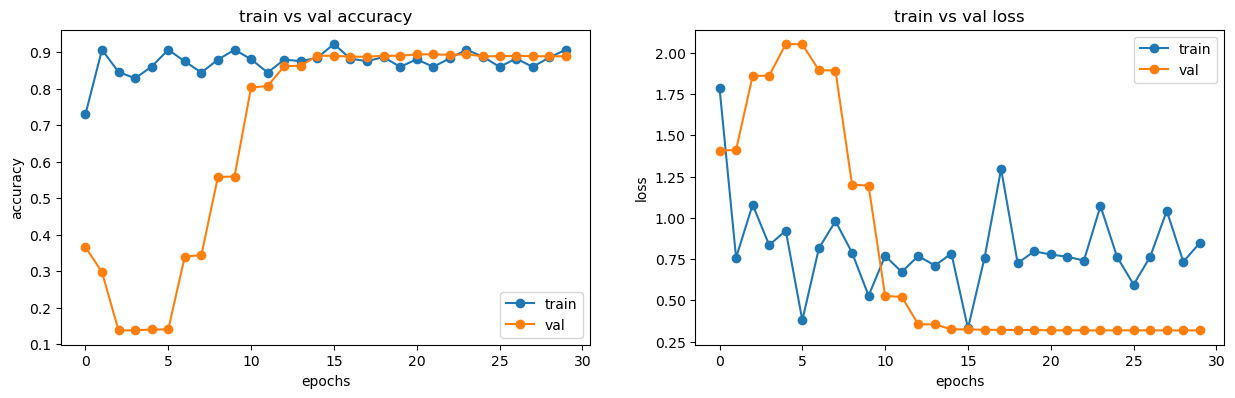

In [80]:
plot_accuracy_loss(CNN_expanded_history)

I am pleased to see a much reduced gap between training and validation data. The augmented data together with the regularization from the Dropout layers has indeed helped.

In [ ]:
# Loading best performing model
# CNN_expanded_loaded = tf.keras.models.load_model("./mlruns/1/CNN_expanded-0.91-08-1-cc1bc89869524569aef10d7edf816cf8.h5")
# CNN_expanded_loaded.evaluate(test_generator)

The accuracy has improved by 0.06 which is not bad but not fantastic either.

In [ ]:
# Plotting learning curves
# plot_confusion_matrix(CNN_expanded, test_generator)
# plot_confusion_matrix(CNN_expanded_loaded, test_generator)

In [ ]:
# Printing the CNN expanded classification report
# show_classification_report(CNN_expanded, test_generator)
# show_classification_report(CNN_expanded_loaded, test_generator)

Both the confusion matrix and the calssification report show an improvement but we are still struggeling with the same misclassification errors albeit to a lesser extent.

In [ ]:
# Val set evaluation
# CNN_expanded.evaluate(val_generator)
# CNN_expanded_loaded.evaluate(val_generator)

A reduced performance on the val set which is surprising. It does seem we have an increase in misscalssified covid observations so the val set may contain some edge cases.

## 4. Transfer learning using MobileNetV3-Small

I have chosen MobileNEtV3-Small because it is an algorythm designed for smartphones and should be very quick and efficient which is important to me due to my lack of GPU.

Another reason is that this model has seen application in very similar tasks as can been seen in the following - [Classification of COVID-19 chest X-Ray and CT images using a type of dynamic CNN modification method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8081579/#fn1). The paper compares the performance of some of the top CNNs on a similar dataset to the one I am using and found that MobileNet was the best performing and least demanding  option.

### 4.1 Transfer learning data generators

The are two aspect of the data which I will need to adjust before I am able to fit it to this model. First of all I need to remove the scaling as MobileNet contains a scaling layer already. I also need to pass RGB images instead of grayscaled ones as that is what the net was trained on. An alternative worth giving a shot could also be to feed the grey scaled images to all 3 channels instead but for now I will go with the RGB option.

In [68]:
# Custom data generator for MobileNEt

# Data augmentation + data generator
train_datagen = ImageDataGenerator(
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=8,
    horizontal_flip=True,
#     validation_split=0.1
)

# No augmentation applied to the test data
test_datagen = ImageDataGenerator()

# Generating
train_generator_transfer = train_datagen.flow_from_directory(
    datasets['xray_train'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

test_generator_transfer = test_datagen.flow_from_directory(
    datasets['xray_test'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
#     class_mode='categorical',
    class_mode='sparse',
    shuffle=False
)

val_generator_transfer = test_datagen.flow_from_directory(
    datasets['xray_val'],
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
#     class_mode='categorical',
    class_mode='sparse',
    shuffle=False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


### 4.2 MobileNEt transfer learning model setup
As is the case with most image calssification models, MobileNEt was trained on Imagenet. Keeping this in mind, the results I am likely going to get will not be as impressive as let's say a dog vs cat calssification using this notwork since the Imagenet dataset does not contain xray images and so the base MobileNet won't be very effective. 

Thankfully the net itself is not all that large and so I should be able to train it to work with chest xray images as well. The current weight of MobileNet should still be able to adapt to the task.

For this model I am also switching to Keras' model API as it will give me some more flexibility that I need for the model exploration a bit later on.

In [71]:
# Importing MobileNetV3Small
mobileNet = MobileNetV3Small(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
mobileNet.trainable = True

In [73]:
# MobileNet model API

def mobilenet_transfer_API():
    
    mobileNet_layers = GlobalAveragePooling2D()(mobileNet.output)
    
#     mobileNet_layers = Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet.output)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)
    
#     mobileNet_layers = Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet_layers)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)
    
#     mobileNet_layers = Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet_layers)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)
    
#     mobileNet_layers = Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet_layers)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)
    
#     mobileNet_layers = Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet_layers)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)
    
#     mobileNet_layers = Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = 'relu')(mobileNet_layers)
#     mobileNet_layers = BatchNormalization()(mobileNet_layers)
# #     mobileNet_layers = MaxPool2D(2,2)(mobileNet_layers)

    mobileNet_layers = Flatten()(mobileNet_layers)
    
    mobileNet_layers = Dense(512, activation = 'relu')(mobileNet_layers)
    mobileNet_layers = Dropout(0.5)(mobileNet_layers)
    
    mobileNet_layers = Dense(256, activation = 'relu')(mobileNet_layers)
    mobileNet_layers = Dropout(0.4)(mobileNet_layers)
    
    mobileNet_layers = Dense(128, activation = 'relu')(mobileNet_layers)
    mobileNet_layers = Dropout(0.3)(mobileNet_layers)
    
    mobileNet_layers = Dense(64, activation = 'relu')(mobileNet_layers)
    mobileNet_layers = Dropout(0.2)(mobileNet_layers)
    
    mobileNet_layers = Dense(4, activation = "softmax")(mobileNet_layers)

    mobileNet_trf = Model(inputs = mobileNet.input, outputs = mobileNet_layers)
    
    return mobileNet_trf

MobileNet_transfer = mobilenet_transfer_API()
MobileNet_transfer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 113, 113, 16)      │               0 │ activation[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 56, 56, 16)        │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 56, 56, 16)        │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 56, 56, 16)        │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1, 1, 16)          │               

 Total params: 1,407,284 (5.37 MB)

 Trainable params: 1,395,172 (5.32 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [75]:
# Setting up a function for the model.fit and model.compile with customizable hparams

def mobilenet_transfer_tuning(details=None, LEARNING_RATE=None, BETA_1=None, EPOCHS=None):
    
    # Optional lr and beta_1 inputs
    if LEARNING_RATE != None and BETA_1 != None and EPOCHS != None:
        LEARNING_RATE = LEARNING_RATE
        BETA_1 = BETA_1
        EPOCHS = EPOCHS
    else:
        # For manual use
        LEARNING_RATE = 1e-7
        BETA_1 = 0.95
        EPOCHS = 2
        
    print("Learning rate: "+str(LEARNING_RATE))
    print("beta_1: "+str(BETA_1))
    print("epochs: "+str(EPOCHS))
      
        
    # Compile model
    MobileNet_transfer.compile(optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1), 
#     MobileNet_transfer.compile(optimizer = SGD(lr=0.01, momentum=0.90, decay=1e-6),                            
                  loss = SparseCategoricalCrossentropy(), 
                  weighted_metrics=["accuracy"],
                  metrics=["accuracy"]
                  )
    
    
    # I want to be able to use this function with or without tracking from MLFlow
    if details:
        details = details       
    else:
        details = timing()
        
#     print("I am inside the history now")
#     print(details)
        
    history = MobileNet_transfer.fit(train_generator_transfer,
                                     batch_size=BATCH_SIZE,
                                     epochs=EPOCHS,
                                     steps_per_epoch=len(train_generator_transfer.classes) // BATCH_SIZE,
                                     validation_data=test_generator_transfer,
                                     shuffle=True,
                                     class_weight=class_weights,
#                                      class_weight={0:8.4, 1:2.9, 2:1, 3:6},
                                     callbacks=[
                                         acc_cp_cb("./Checkpoints/MobileNet_transfer/MobileNet_transfer-{val_accuracy:.2f}-{epoch:02d}"+f"-{details}.keras"),
                                         tb_cb(f"./TensorBoard/MobileNet_transfer/MobileNet_transfer-{details}"),
#                                          es_cb,
                                         lr_plateau_cb])
    return history

In [77]:
# # Manual search cell
# mlflow.tensorflow.autolog(disable=True) # When I am loggin I will be doing it using the below cell
# # tf.keras.backend.clear_session()
# MobileNet_transfer = mobilenet_transfer_API()

# MobileNet_transfer_history = mobilenet_transfer_tuning(details = None, LEARNING_RATE = 1e-3, BETA_1 = 0.95, EPOCHS = 30)

In [79]:
# mlflow.create_experiment(name = 'MobileNet_transfer') # id 2

In [86]:
# Loop for hparam tuning
for LEARNING_RATE, BETA_1, EPOCHS in [
#     [1e-3, 0.90, 3], [1e-4, 0.90, 3], [1e-5, 0.90, 3],
#     [1e-3, 0.95, 3], [1e-4, 0.95, 3], [1e-5, 0.95, 3],
    [1e-3, 0.95, 30]
]:

    # Reset model
#     tf.keras.backend.clear_session()
    MobileNet_transfer = mobilenet_transfer_API()
    
    # Tracking func which runs the tuning func with the given parameters
    
    MobileNet_transfer_history = mlflow_tracking(
        model_name = "MobileNet_transfer", 
        model_history = mobilenet_transfer_tuning, 
        LEARNING_RATE = LEARNING_RATE, 
        BETA_1 = BETA_1, 
        EPOCHS = EPOCHS)

Traceback (most recent call last):
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1339, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksbon\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1332, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ksb

Learning rate: 0.001
beta_1: 0.95
epochs: 30


2024/06/09 10:43:01 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/06/09 10:43:01 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8537 - loss: 1.2771 - weighted_accuracy: 0.8239
Epoch 1: val_accuracy improved from -inf to 0.85344, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.85-01-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8544 - loss: 1.2714 - weighted_accuracy: 0.8249 - val_accuracy: 0.8534 - val_loss: 3.0802 - val_weighted_accuracy: 0.8534 - learning_rate: 0.0010
Epoch 2/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9688 - loss: 0.5412 - weighted_accuracy: 0.9330

C:\Users\ksbon\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.85344 to 0.85863, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.86-02-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9688 - loss: 0.5412 - weighted_accuracy: 0.9330 - val_accuracy: 0.8586 - val_loss: 3.0793 - val_weighted_accuracy: 0.8586 - learning_rate: 0.0010
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9597 - loss: 0.3321 - weighted_accuracy: 0.9636
Epoch 3: val_accuracy did not improve from 0.85863
98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9596 - loss: 0.3321 - weighted_accuracy: 0.9637 - val_accuracy: 0.7302 - val_loss: 4.2643 - val_weighted_accuracy: 0.7302 - learning_rate: 0.0010
Epoch 4/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9688 - loss: 0.1597 - weighted_accuracy: 0.9882
Epoch 4: val_accuracy did not improve from 0.85863
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9688 - loss: 0.1597 - weighted_accuracy: 0.9882 - val_accuracy: 0.7289 - val_loss: 4.3930 - val_weighted_accuracy: 0.7289 - learning_rate: 0.0010
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9611 - 

98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9688 - loss: 0.0622 - weighted_accuracy: 0.9875 - val_accuracy: 0.7808 - val_loss: 8.4359 - val_weighted_accuracy: 0.7808 - learning_rate: 1.0000e-04
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9722 - loss: 0.1451 - weighted_accuracy: 0.9822
Epoch 7: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9722 - loss: 0.1451 - weighted_accuracy: 0.9822 - val_accuracy: 0.7808 - val_loss: 5.1471 - val_weighted_accuracy: 0.7808 - learning_rate: 1.0000e-04
Epoch 8/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9531 - loss: 0.1169 - weighted_accuracy: 0.9799
Epoch 8: val_accuracy did not improve from 0.85863

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9531 - loss: 0.1169 - weighted_accuracy: 0.9799 - val_accuracy: 0.7808 - val_loss: 5.1160 - val_weighted_accuracy: 0.7808 - learning_rate: 1.0000e-04
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9782 - loss: 0.1339 - weighted_accuracy: 0.9843
Epoch 9: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9782 - loss: 0.1338 - weighted_accuracy: 0.9843 - val_accuracy: 0.7938 - val_loss: 3.7063 - val_weighted_accuracy: 0.7938 - learning_rate: 1.0000e-05
Epoch 10/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.9844 - loss: 0.0907 - weighted_accuracy: 0.9939
Epoch 10: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9844 - loss: 0.0907 - weighted_accuracy: 0.9939 - val_accuracy: 0.7938 - val_loss: 3.6938 - val_weighted_accuracy: 0.7938 - learning_rate: 1.0000e-05
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9775 - loss: 0.1245 - weighted_accuracy: 0.9860
Epoch 11: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9775 - loss: 0.1244 - weighted_accuracy: 0.9860 - val_accuracy: 0.8067 - val_loss: 2.7454 - val_weighted_accuracy: 0.8067 - learning_rate: 1.0000e-05
Epoch 12/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9688 - loss: 0.0939 - weighted_accuracy: 0.9880
Epoch 12: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9688 - loss: 0.0939 - weighted_accuracy: 0.9880 - val_accuracy: 0.8067 - val_loss: 2.7385 - val_weighted_accuracy: 0.8067 - learning_rate: 1.0000e-05
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9810 - loss: 0.1093 - weighted_accuracy: 0.9869
Epoch 13: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9809 - loss: 0.1096 - weighted_accuracy: 0.9869 - val_accuracy: 0.8184 - val_loss: 2.0312 - val_weighted_accuracy: 0.8184 - learning_rate: 1.0000e-05
Epoch 14/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9844 - loss: 0.0573 - weighted_accuracy: 0.9938
Epoch 14: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9844 - loss: 0.0573 - weighted_accuracy: 0.9938 - val_accuracy: 0.8184 - val_loss: 2.0247 - val_weighted_accuracy: 0.8184 - learning_rate: 1.0000e-05
Epoch 15/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9800 - loss: 0.1029 - weighted_accuracy: 0.9879
Epoch 15: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9800 - loss: 0.1028 - weighted_accuracy: 0.9879 - val_accuracy: 0.8405 - val_loss: 1.4886 - val_weighted_accuracy: 0.8405 - learning_rate: 1.0000e-05
Epoch 16/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9688 - loss: 0.2049 - weighted_accuracy: 0.9437
Epoch 16: val_accuracy did not improve from 0.85863


98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9688 - loss: 0.2049 - weighted_accuracy: 0.9437 - val_accuracy: 0.8405 - val_loss: 1.4829 - val_weighted_accuracy: 0.8405 - learning_rate: 1.0000e-05
Epoch 17/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9782 - loss: 0.1309 - weighted_accuracy: 0.9835
Epoch 17: val_accuracy improved from 0.85863 to 0.86252, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.86-17-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9781 - loss: 0.1309 - weighted_accuracy: 0.9835 - val_accuracy: 0.8625 - val_loss: 1.1172 - val_weighted_accuracy: 0.8625 - learning_rate: 1.0000e-05
Epoch 18/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9531 - loss: 0.2538 - weighted_accuracy: 0.9590
Epoch 18: val_accuracy did not improve from 0.86252


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9531 - loss: 0.2538 - weighted_accuracy: 0.9590 - val_accuracy: 0.8625 - val_loss: 1.1146 - val_weighted_accuracy: 0.8625 - learning_rate: 1.0000e-05
Epoch 19/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9773 - loss: 0.1251 - weighted_accuracy: 0.9847
Epoch 19: val_accuracy improved from 0.86252 to 0.87549, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.88-19-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9773 - loss: 0.1252 - weighted_accuracy: 0.9847 - val_accuracy: 0.8755 - val_loss: 0.8342 - val_weighted_accuracy: 0.8755 - learning_rate: 1.0000e-05
Epoch 20/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9844 - loss: 0.0671 - weighted_accuracy: 0.9934
Epoch 20: val_accuracy did not improve from 0.87549


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9844 - loss: 0.0671 - weighted_accuracy: 0.9934 - val_accuracy: 0.8755 - val_loss: 0.8319 - val_weighted_accuracy: 0.8755 - learning_rate: 1.0000e-05
Epoch 21/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9785 - loss: 0.1405 - weighted_accuracy: 0.9859
Epoch 21: val_accuracy improved from 0.87549 to 0.88457, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.88-21-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9785 - loss: 0.1404 - weighted_accuracy: 0.9859 - val_accuracy: 0.8846 - val_loss: 0.6476 - val_weighted_accuracy: 0.8846 - learning_rate: 1.0000e-05
Epoch 22/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9688 - loss: 0.1072 - weighted_accuracy: 0.9844
Epoch 22: val_accuracy did not improve from 0.88457


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9688 - loss: 0.1072 - weighted_accuracy: 0.9844 - val_accuracy: 0.8833 - val_loss: 0.6460 - val_weighted_accuracy: 0.8833 - learning_rate: 1.0000e-05
Epoch 23/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9764 - loss: 0.1224 - weighted_accuracy: 0.9855
Epoch 23: val_accuracy improved from 0.88457 to 0.89105, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.89-23-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9764 - loss: 0.1223 - weighted_accuracy: 0.9855 - val_accuracy: 0.8911 - val_loss: 0.5208 - val_weighted_accuracy: 0.8911 - learning_rate: 1.0000e-05
Epoch 24/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9844 - loss: 0.1088 - weighted_accuracy: 0.9802
Epoch 24: val_accuracy did not improve from 0.89105


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9844 - loss: 0.1088 - weighted_accuracy: 0.9802 - val_accuracy: 0.8911 - val_loss: 0.5196 - val_weighted_accuracy: 0.8911 - learning_rate: 1.0000e-05
Epoch 25/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9830 - loss: 0.0965 - weighted_accuracy: 0.9877
Epoch 25: val_accuracy improved from 0.89105 to 0.90402, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.90-25-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9829 - loss: 0.0967 - weighted_accuracy: 0.9877 - val_accuracy: 0.9040 - val_loss: 0.4288 - val_weighted_accuracy: 0.9040 - learning_rate: 1.0000e-05
Epoch 26/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9688 - loss: 0.0637 - weighted_accuracy: 0.9704
Epoch 26: val_accuracy did not improve from 0.90402


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9688 - loss: 0.0637 - weighted_accuracy: 0.9704 - val_accuracy: 0.9040 - val_loss: 0.4279 - val_weighted_accuracy: 0.9040 - learning_rate: 1.0000e-05
Epoch 27/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9787 - loss: 0.1080 - weighted_accuracy: 0.9847
Epoch 27: val_accuracy improved from 0.90402 to 0.91569, saving model to ./Checkpoints/MobileNet_transfer/MobileNet_transfer-0.92-27-408449089731872812-e39b8e7c1ab9423c979ca7ad75514208.keras


98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9787 - loss: 0.1081 - weighted_accuracy: 0.9847 - val_accuracy: 0.9157 - val_loss: 0.3591 - val_weighted_accuracy: 0.9157 - learning_rate: 1.0000e-05
Epoch 28/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 1.0000 - loss: 0.0187 - weighted_accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.91569


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 1.0000 - loss: 0.0187 - weighted_accuracy: 1.0000 - val_accuracy: 0.9157 - val_loss: 0.3588 - val_weighted_accuracy: 0.9157 - learning_rate: 1.0000e-05
Epoch 29/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9788 - loss: 0.1159 - weighted_accuracy: 0.9870
Epoch 29: val_accuracy did not improve from 0.91569


98/98 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9788 - loss: 0.1159 - weighted_accuracy: 0.9870 - val_accuracy: 0.9157 - val_loss: 0.3251 - val_weighted_accuracy: 0.9157 - learning_rate: 1.0000e-05
Epoch 30/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 993ms/step - accuracy: 0.9844 - loss: 0.0385 - weighted_accuracy: 0.9932
Epoch 30: val_accuracy did not improve from 0.91569


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9844 - loss: 0.0385 - weighted_accuracy: 0.9932 - val_accuracy: 0.9157 - val_loss: 0.3249 - val_weighted_accuracy: 0.9157 - learning_rate: 1.0000e-05


2024/06/09 11:36:13 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/06/09 11:36:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/06/09 11:36:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ksbon\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils."


### 4.2.1 MobileNet_transfer model evaluation

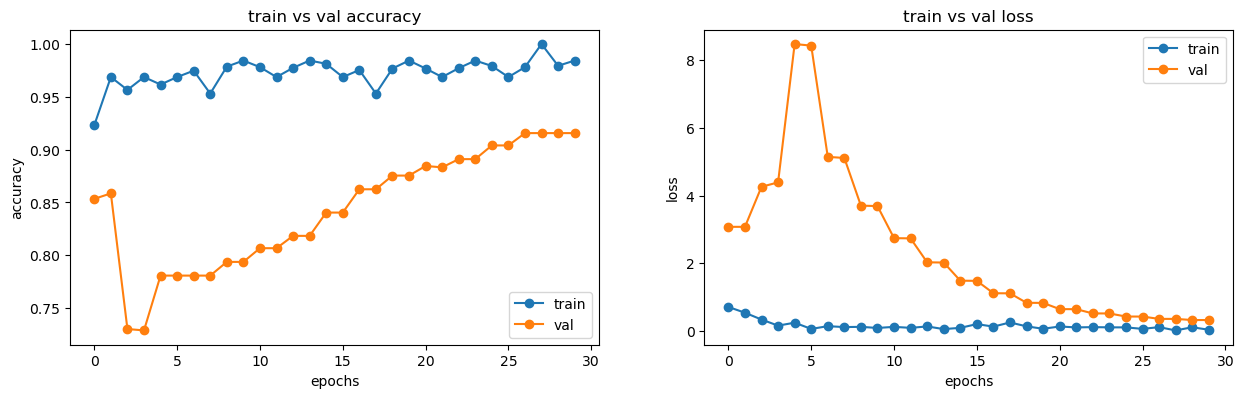

In [87]:
# Plot learning curves
plot_accuracy_loss(MobileNet_transfer_history)

A much better looking training curve this time around. Both converge nad the train-val gap is the smallest we've got so far.

### Best MobileNet_transfer model test set performance

In [121]:
# Loading best MobileNet_transfer model

# MobileNet_transfer_loaded = tf.keras.models.load_model("./mlruns/2/23eea4a5205348fe9245792b35362a81/artifacts/model/data/model")
# MobileNet_transfer_loaded.evaluate(test_generator_transfer)

An improvement of 0.04 which gets is up to an accuracy of 0.94. Pretty good under the circustance though I was hoping to be closer to 98% accuracy.

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step


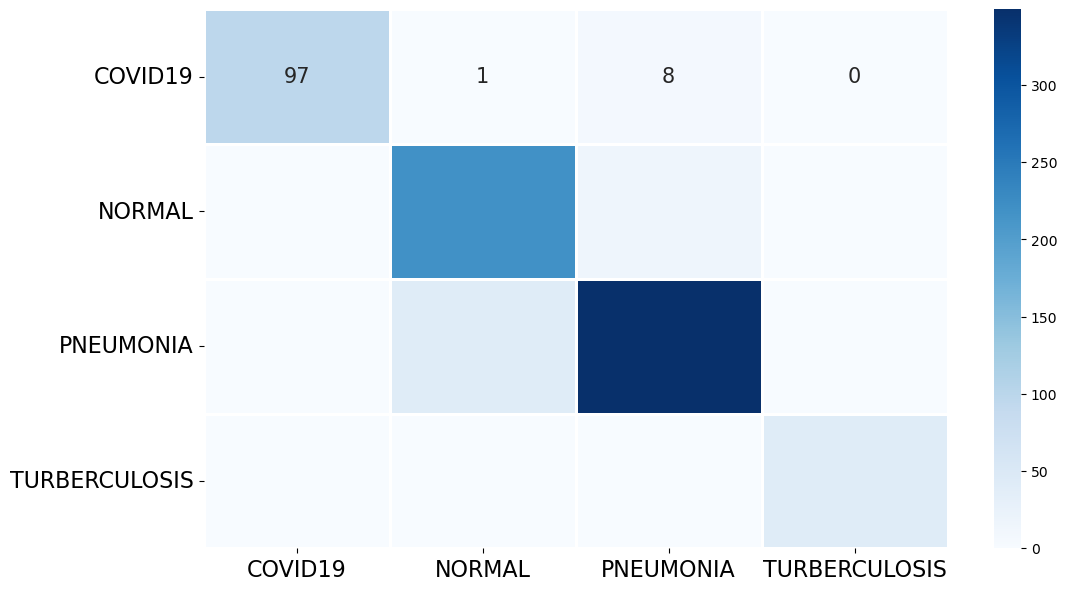

In [88]:
# Plotting test set confusion matrix

plot_confusion_matrix(MobileNet_transfer, test_generator_transfer)
# plot_confusion_matrix(MobileNet_transfer_loaded, test_generator_transfer)

In [89]:
# Printing test set classification report

show_classification_report(MobileNet_transfer, test_generator_transfer)
# show_classification_report(MobileNet_transfer_loaded, test_generator_transfer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 685ms/step
              precision    recall  f1-score   support

       Covid       1.00      0.92      0.96       106
      Normal       0.84      0.94      0.88       234
   Pneumonia       0.94      0.89      0.92       390
Tuberculosis       1.00      1.00      1.00        41

    accuracy                           0.92       771
   macro avg       0.94      0.94      0.94       771
weighted avg       0.92      0.92      0.92       771



Normal and Pneumonia are still our worst classes score wise. Presumably TB is not that pronounced if it is that close to some of the Normal images.

### Best MobileNet_transfer model val set performance

In [138]:
MobileNet_transfer_loaded = MobileNet_transfer
MobileNet_transfer_loaded.evaluate(val_generator_transfer)

C:\Users\ksbon\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.8684 - loss: 0.3531 - weighted_accuracy: 0.8684


[0.3530811071395874,
 0.8684210777282715,
 0.8684210777282715,
 0.8684210777282715]

This model is having a very good time with the val set though considering the set's limited size it is not all that indicative of the model's performance. The models do keep getting better scores on the val set as compared to the test set so it does seem to be a bit easier containing observation with a better calss separation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


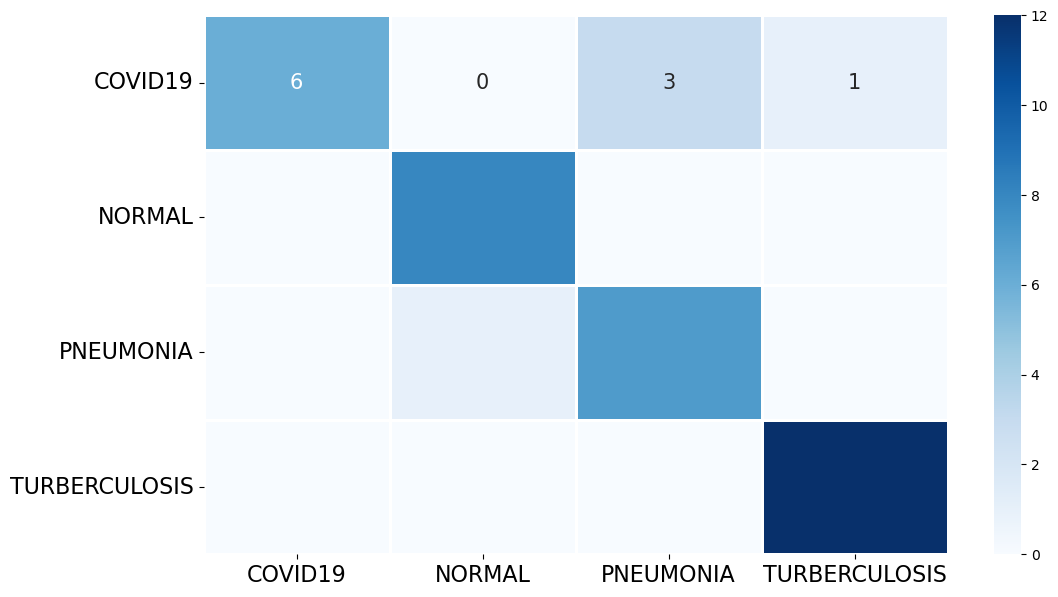

In [141]:
plot_confusion_matrix(MobileNet_transfer_loaded, val_generator_transfer)

In [143]:
show_classification_report(MobileNet_transfer_loaded, val_generator_transfer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
              precision    recall  f1-score   support

       Covid       1.00      0.60      0.75        10
      Normal       0.89      1.00      0.94         8
   Pneumonia       0.70      0.88      0.78         8
Tuberculosis       0.92      1.00      0.96        12

    accuracy                           0.87        38
   macro avg       0.88      0.87      0.86        38
weighted avg       0.89      0.87      0.86        38



### 4.2.2 Testing MobileNet_transfer on random images

Let's play around a bit with the best performing model. I'll take some random images from "a popular search engine" and see how the model performs.

In [146]:
# MobileNet_transfer_loaded = MobileNet_transfer_loaded = tf.keras.models.load_model("./mlruns/2/23eea4a5205348fe9245792b35362a81/artifacts/model/data/model")
MobileNet_transfer_loaded.evaluate(test_generator_transfer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 701ms/step - accuracy: 0.8886 - loss: 0.3812 - weighted_accuracy: 0.8886


[0.3398244082927704,
 0.9092088341712952,
 0.9092088341712952,
 0.9092088341712952]

In [147]:
# Setting up a function to display the images and the probabilities per class

def predict_class(model, image_urls):
    
    for image_url in image_urls:
        
        # Preprocess image
        img = imread(image_url)
        img = resize(img, IMAGE_SIZE, preserve_range=True)
        img = tf.keras.applications.imagenet_utils.preprocess_input(img) # scale pixels between -1 and 1
        img = tf.expand_dims(img, axis = 0)
        prediction = model.predict(img)
        
        # Ploting image
        plt.figure(figsize=(9,9))
        imshow(image_url)
        plt.show()
        
        # Printing probabilities
        print("Covid19 probability:", format(prediction[0][0],'.2f'))
        print("Normal probability:", format(prediction[0][1],'.2f'))
        print("Pneumonia probability:", format(prediction[0][2],'.2f'))
        print("Tuberculosis probability:", format(prediction[0][3],'.2f'))

In [148]:
# Covid urls
covid_xray_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRY65-ch1CiVlTsdY-ycM1RYyA5TIPOiQt3ohovA8H_W5e5hVscEuULGWPwzoWQORrluZY&usqp=CAU"

# Normal urls
normal_xray_url = "https://www.saem.org/images/default-source/cdems/214f54a4e822ce4862929b07a3d049a3f1.png?sfvrsn=6a9aec7b_0"

# Pneumonia urls
pneumonia_xray_url = "https://previews.123rf.com/images/sopone/sopone1811/sopone181100033/113899029-a-chest-xray-film-of-a-patient-with-right-upper-lung-pneumonia-.jpg"

# TB urls
tuberculosis_xray_url = "https://upload.wikimedia.org/wikipedia/commons/2/2b/Dense_opacity_of_primary_pulmonary_tuberculosis.jpg"

# Special urls
blue_xray_url = "https://informaconnect.com/article/images/cacheable/bd64cf28-498e-44df-be77-3e74cd079783-0-0e10f9c3c3671c91e48b35d17933997b.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


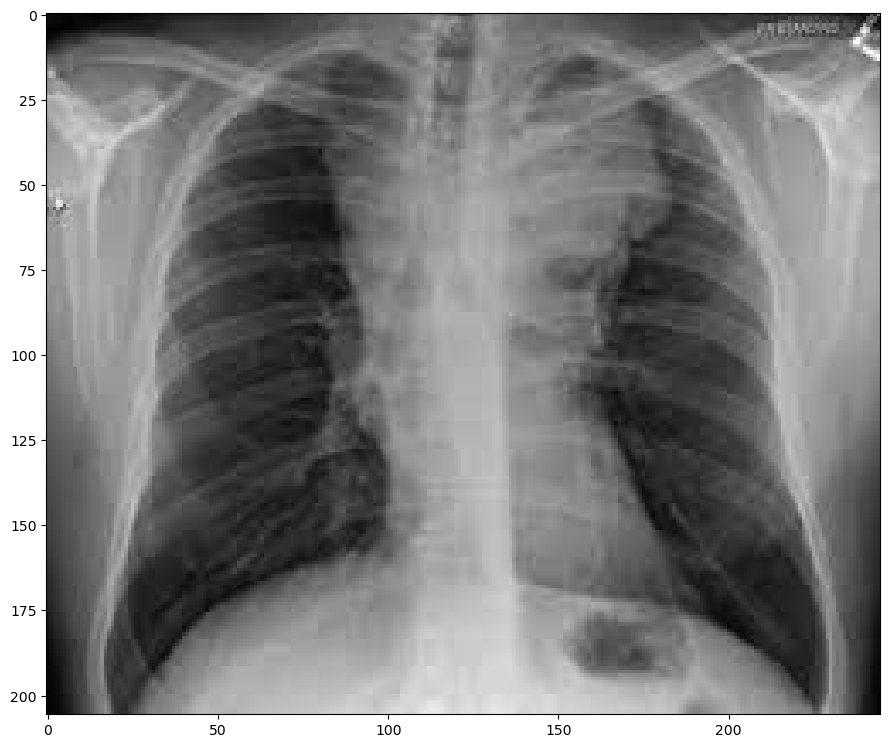

Covid19 probability: 0.00
Normal probability: 0.00
Pneumonia probability: 0.00
Tuberculosis probability: 1.00


In [149]:
covid_xray_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRY65-ch1CiVlTsdY-ycM1RYyA5TIPOiQt3ohovA8H_W5e5hVscEuULGWPwzoWQORrluZY&usqp=CAU"

# Predict list of images and class activations
predict_class(MobileNet_transfer_loaded, [covid_xray_url])

Right off the bat we get a misclassification of a Covid xray.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


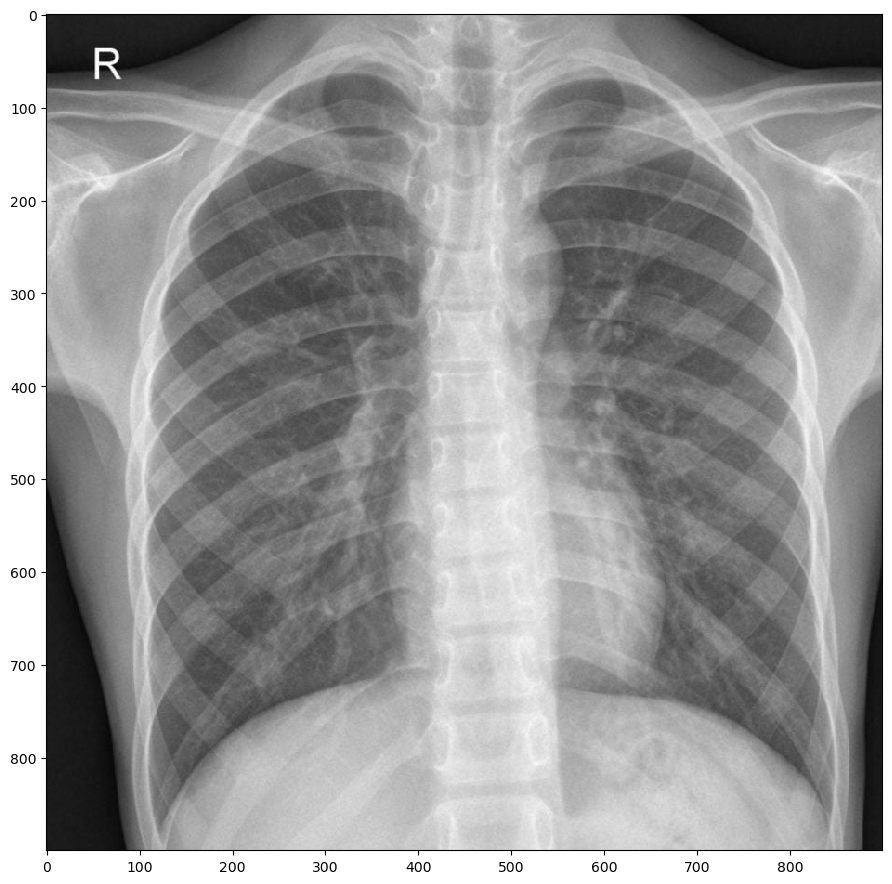

Covid19 probability: 0.13
Normal probability: 0.04
Pneumonia probability: 0.11
Tuberculosis probability: 0.72


In [151]:
normal_xray_url = "https://f.hubspotusercontent30.net/hubfs/1553939/Imported_Blog_Media/IM-0005-0001_jpeg-e1585651946797.jpg"


predict_class(MobileNet_transfer_loaded, [normal_xray_url])

The healthy chest xray pulled from the internet also doesn't do much better. The model is favouring TB for some reason, despite it not being the most represented class in the data. Perhaps the model's view of TB is too general.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


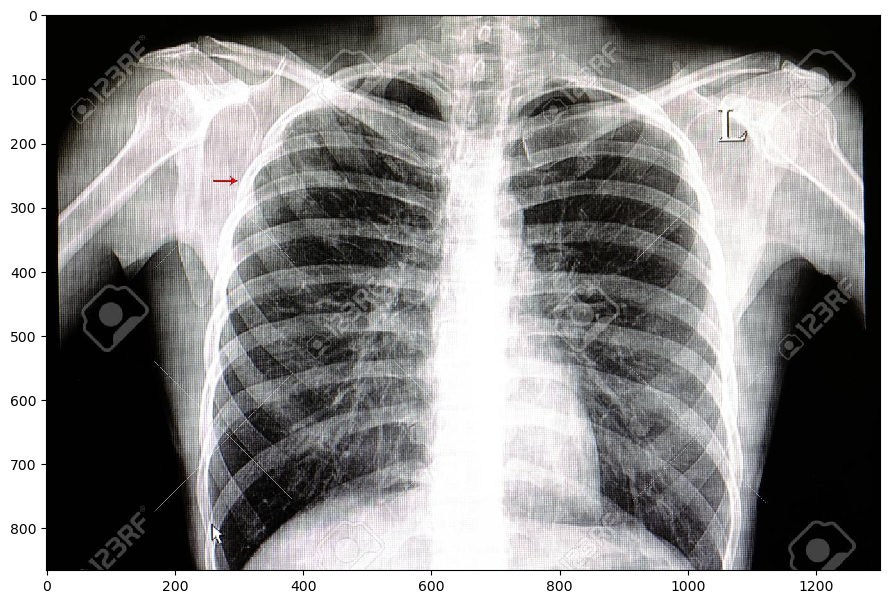

Covid19 probability: 0.01
Normal probability: 0.00
Pneumonia probability: 0.00
Tuberculosis probability: 0.98


In [153]:
pneumonia_xray_url = "https://previews.123rf.com/images/sopone/sopone1811/sopone181100033/113899029-a-chest-xray-film-of-a-patient-with-right-upper-lung-pneumonia-.jpg"
predict_class(MobileNet_transfer_loaded, [pneumonia_xray_url])

Same issue here with the pneumonia image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


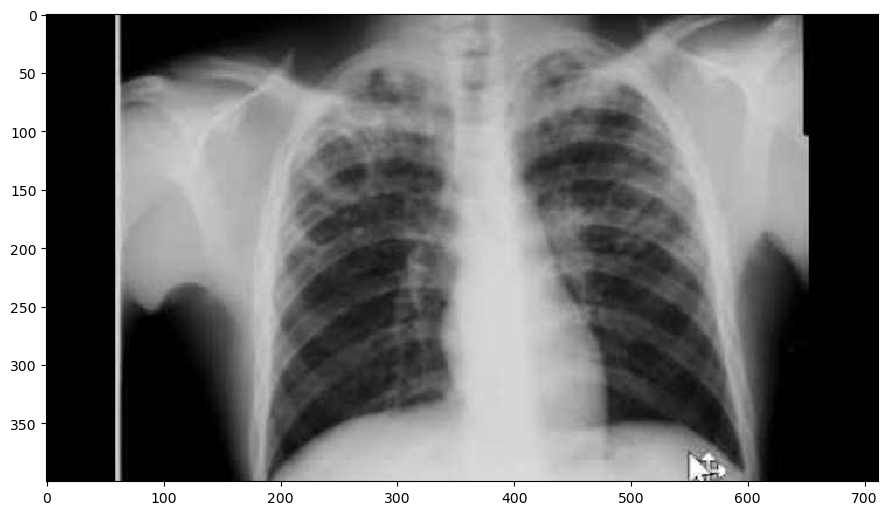

Covid19 probability: 0.00
Normal probability: 0.00
Pneumonia probability: 0.00
Tuberculosis probability: 1.00


In [155]:
tuberculosis_xray_url = "https://www.healthcareitnews.com/sites/hitn/files/Tubeculosis%20chest%20X-ray%20-Youtube.jpg"
predict_class(MobileNet_transfer_loaded, [tuberculosis_xray_url])

Unsurprisingly we do get the TB image correct. I am not going to credit that to the model as it has classified everything so far as the same class. Broken watches, right?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


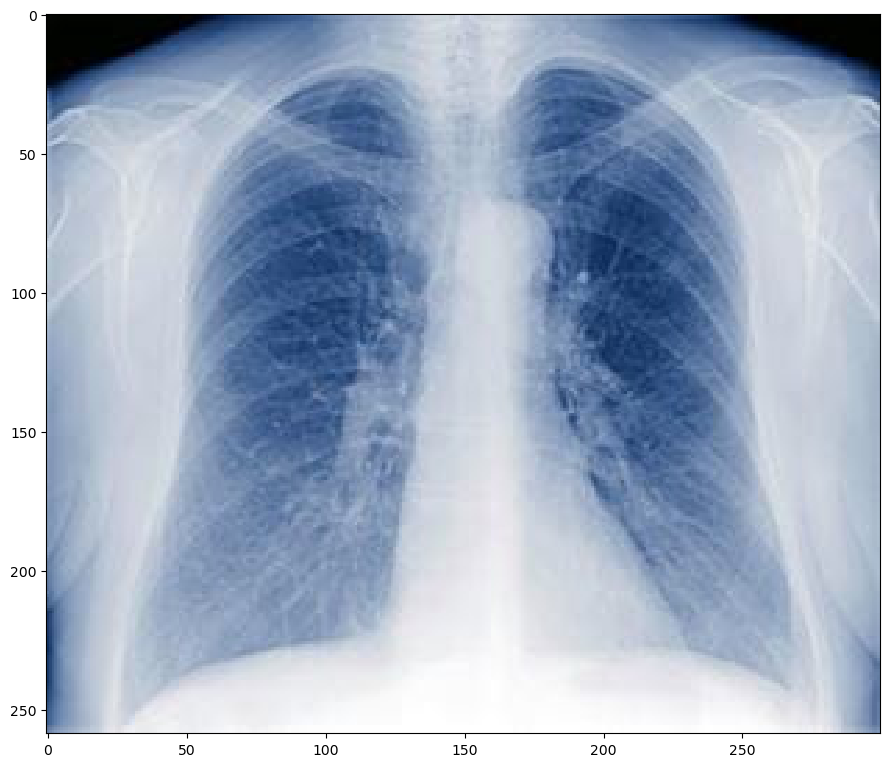

Covid19 probability: 0.00
Normal probability: 0.00
Pneumonia probability: 0.00
Tuberculosis probability: 1.00


In [157]:
blue_xray_url = "https://www.phidenverhealth.org/-/media/images/modules/news/dph-news-images/lung-image-small.jpg?h=259&w=300&hash=0A8466294635C46DEADEEDE6726F036E"
predict_class(MobileNet_transfer_loaded, [blue_xray_url])

I am trying this image just because I was curious how the model would react to a blue one. Pretty high TB certainty so maybe it is indeed responding to the color blue in relation to the TB class.

## 5 Model explainability and visualisation 
I want to get a better understanding of why the model is performing in such a way.

### 5.1 Layer visualization

Let's start by visualizing the first layer kernels. At this stage we can still use all 3 image channels and display each kernel as a BGR image instead of a series of black and white ones.

In [183]:
first_layer_weights = MobileNet_transfer_loaded.get_layer("conv").get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 16)

Rescaling  0-1

In [186]:
def rescale_values(array):
    if not isinstance(array, np.ndarray):
        array = np.array(array)
    array_min, array_max = array.min(), array.max()
    return (array - array_min)/(array_max - array_min)

In [188]:
def show_image(current_image, axis):
    current_image = rescale_values(current_image)
    if current_image.shape[-2] == 3: #RGB image
        current_image = current_image[:,:,::-1] #RGB -> BRG
        axis.imshow(current_image)
    else: # If grayscale
        axis.imshow(current_image.squeeze(), cmap = 'gray')
    axis.set_xticks([])
    axis.set_yticks([])
    
def show_figure(rows, cols, figure_size, images_to_plot, title):
    fig, axes = plt.subplots(rows, cols, figsize = figure_size)
    for row in range(rows):
        for col in range(cols):
            show_image(images_to_plot[:, :, :, row, col], axes[row][col])
    fig.patch.set_facecolor("black")
    fig.suptitle(title, color = "white", y = 0.94)
    plt.show()

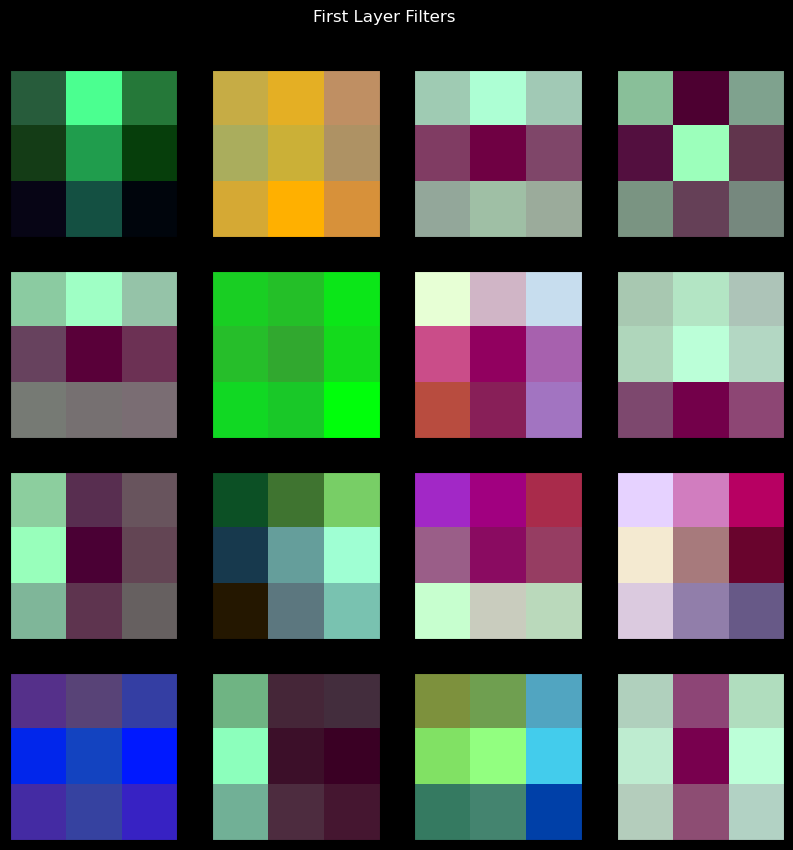

In [190]:
filter_size, _, filter_depth, num_filters = first_layer_weights.shape
rows, cols = 4, 4
ordered_weights = first_layer_weights.reshape(filter_size, filter_size, filter_depth, rows, cols)
show_figure(rows, cols, (10 ,10), images_to_plot = ordered_weights, title = "First Layer Filters")

I am seeing some color that i did not expect, namely light green and orange. Orange in particular looks a bit odd to me but it might very well be due to the model's previous training on Imagenet. There is quite a lot of the light green xray color which is nice but also quite a bit of purple and some blue which is interesting as well since there are quite a few purple or blue images in the dataset.

### Visualizing layer activations
We can also display the convolutional layer outputs after the activation function has been applied. I'll start by creating a dummy model with the output pointing to the layer I'd like to view.


In [194]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [198]:
# from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

img_path = "../data/Chest X-Rays/val/COVID19/COVID19(573).jpg"

input_image = tf.keras.applications.mobilenet_v3.preprocess_input(get_img_array(img_path, size=IMAGE_SIZE))

### First layer activations

 Since the input is  224×224  and there are 16 kernels, we can display 16 black-and-white full-size images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


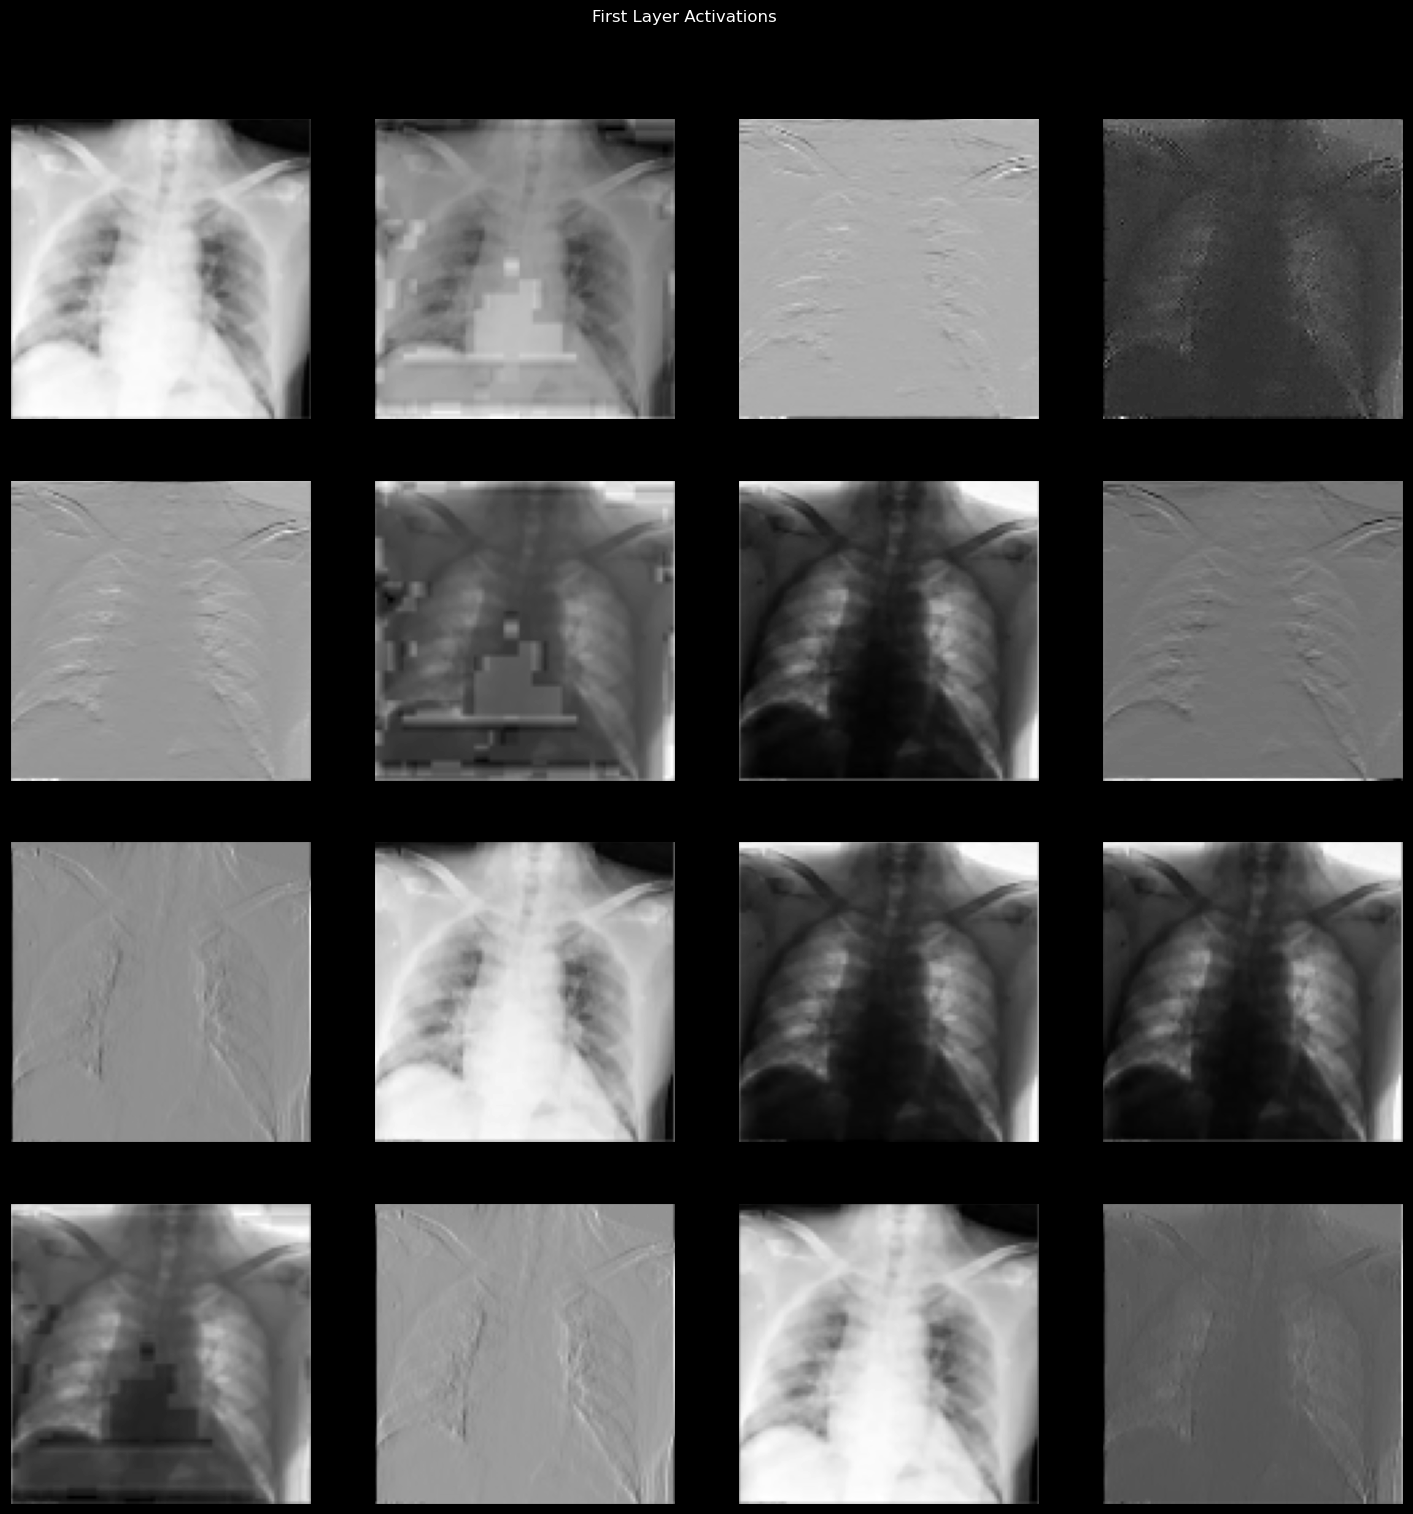

In [200]:
# Retrieving model layer output
first_layer_model = Model(inputs = MobileNet_transfer_loaded.inputs, outputs = MobileNet_transfer_loaded.get_layer("conv").output)

# Retrieving activations
activations = first_layer_model.predict(input_image)[0]

# Reshaping and plotting activations
rows, cols = 4, 4
activation_size, _, num_filters = activations.shape
ordered_activations = activations.reshape(activation_size, activation_size, 1, rows, cols)
show_figure(rows=rows, 
            cols=cols, 
            figure_size=(18, 18), 
            images_to_plot = ordered_activations, 
            title = "First Layer Activations")

Lighter colors represent higher activations. We can see that certain filters pick up certain features. Some seem to isolate the foreground and background, others seem to focus on horizontal and vertical edges. The model does seem to have learned some usefult features. 

 Let's move onto one of the layer in the middle of the model. Layer 5 has 240 features which we can visualize in a 16x15 grid.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


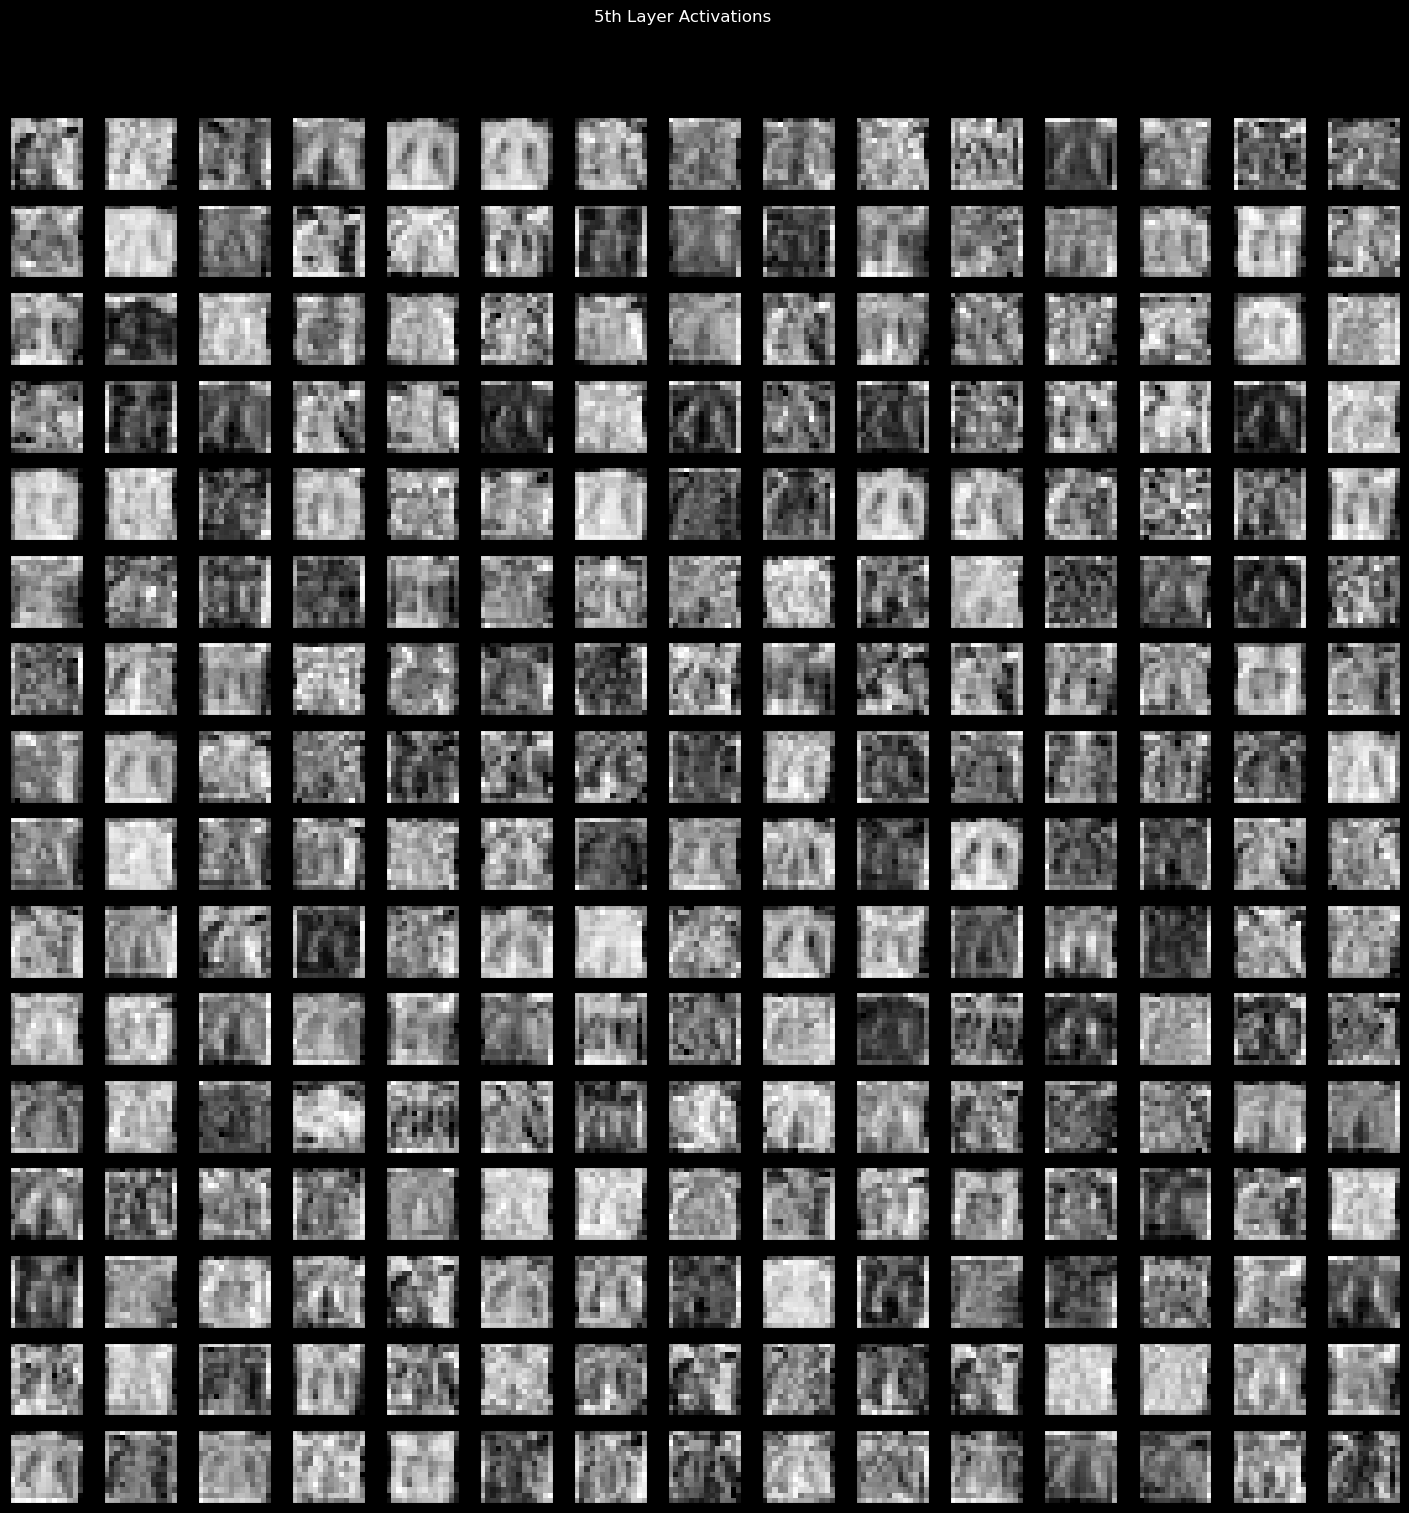

In [206]:
# Retrieving model layer output
fifth_layer_model = Model(inputs = MobileNet_transfer_loaded.inputs, outputs = MobileNet_transfer_loaded.get_layer("expanded_conv_5_expand").output)

# Retrieving activations
fifth_layer_activations = fifth_layer_model.predict(input_image)[0]
image_size, _, num_images = fifth_layer_activations.shape

# Reshaping and plotting activations
rows, cols = 16, 15
ordered_fifth_layer_activations = fifth_layer_activations.reshape(image_size, image_size, 1, rows, cols)
show_figure(rows=rows, 
            cols=cols, 
            figure_size=(18, 18), 
            images_to_plot = ordered_fifth_layer_activations, 
            title = "5th Layer Activations")

We can still kind of make out the overall shape of the image in some cases (not so much in others). the level of detail per activation has gone down. It does seem that there is quite a bit of white amongs these images which may signify too much activation on features that are not that important.

Let's do this exercise one last time for the final convolutional layer of the model. For this layer we have 576 features which we can display as a 24x24 grid.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


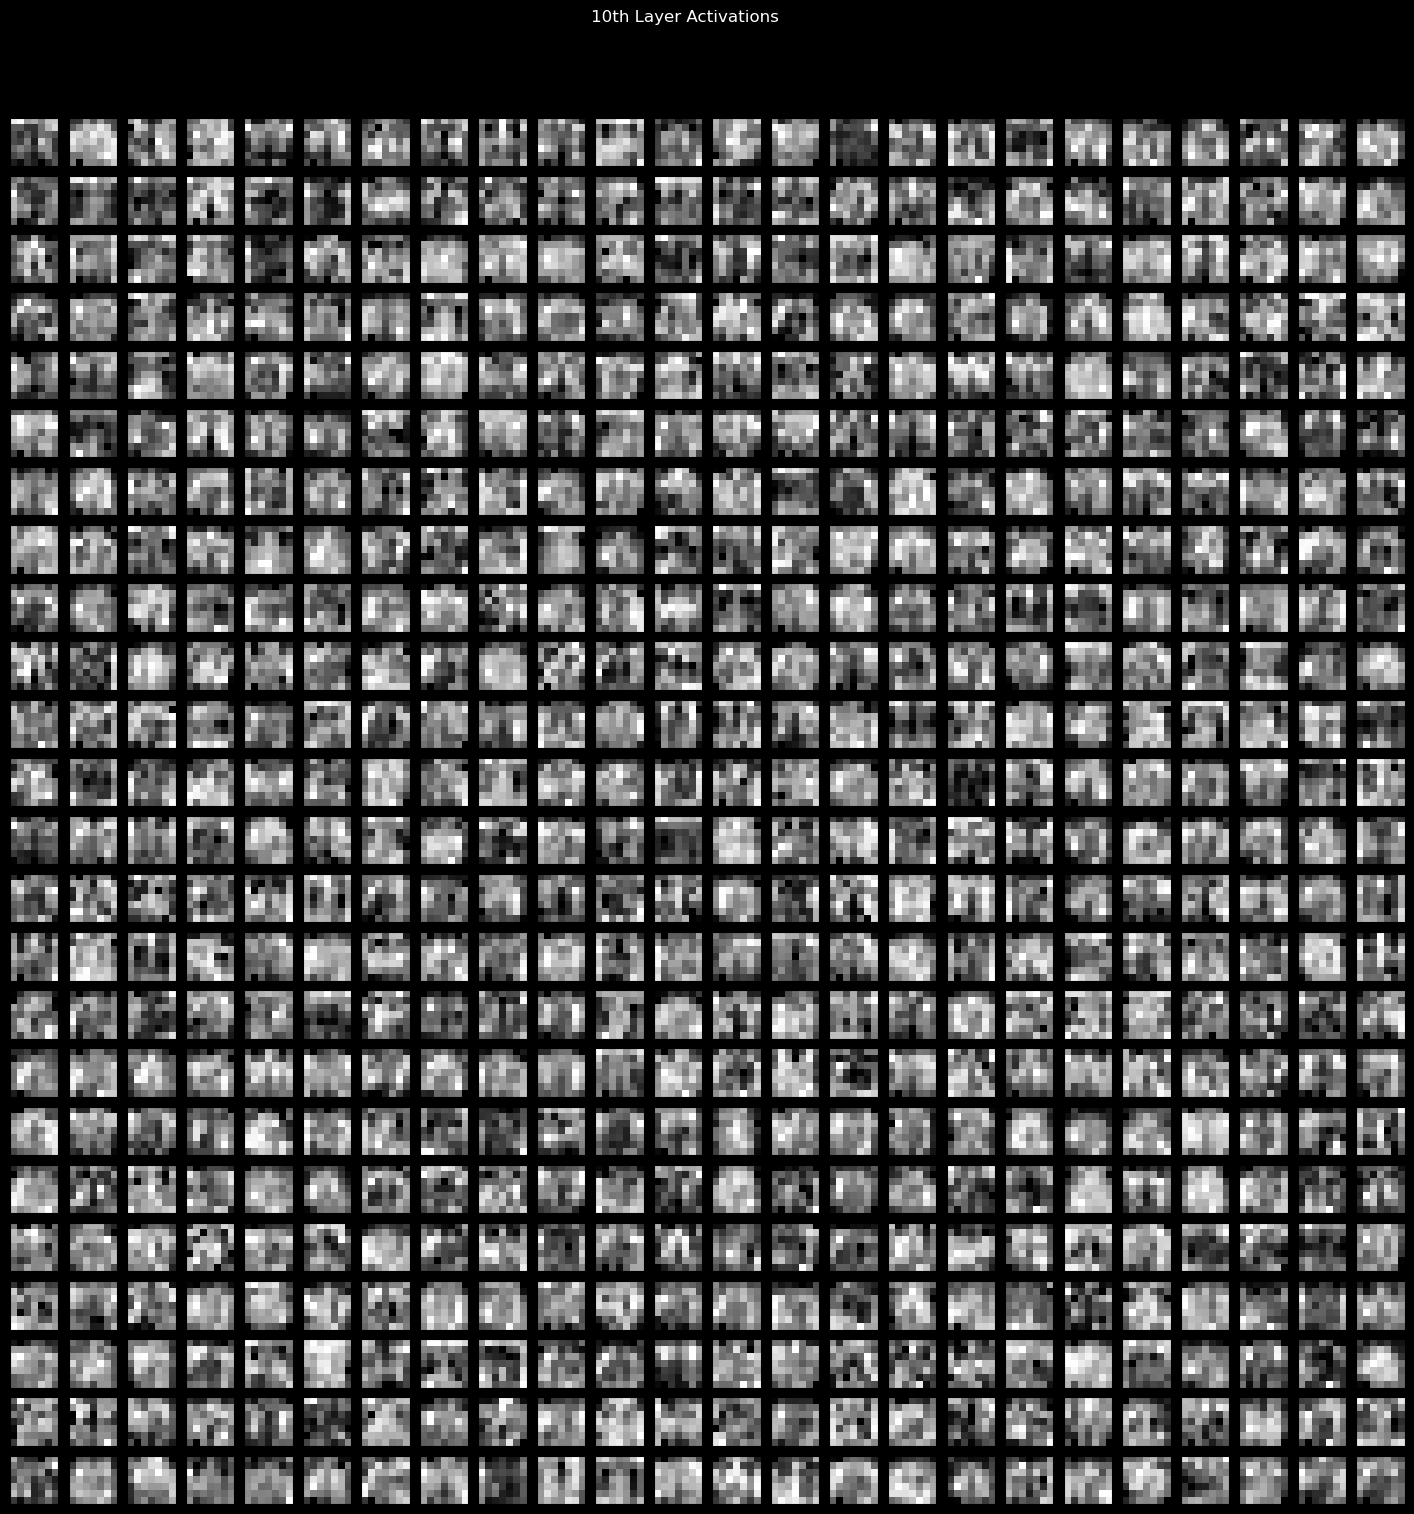

In [211]:
# Retrieving model layer output
tenth_layer_model = Model(inputs = MobileNet_transfer_loaded.inputs, outputs = MobileNet_transfer_loaded.get_layer("expanded_conv_10_expand").output)

# Retrieving activations
tenth_layer_activations = tenth_layer_model.predict(input_image)[0]
image_size, _, num_images = tenth_layer_activations.shape

# Reshaping and plotting activations
rows, cols = 24, 24
ordered_tenth_layer_activations = tenth_layer_activations.reshape(image_size, image_size, 1, rows, cols)
show_figure(rows=rows, 
            cols=cols, 
            figure_size=(18, 18), 
            images_to_plot = ordered_tenth_layer_activations, 
            title = "10th Layer Activations")

At this stage we have almost entirely lost any interpretability. Much like the previous visualized layer, there is quite a lot of activation at this stage which may signify a certain level of overfitting.

### 5.2 Grad-CAM Visualization

Let's try and get some deeper understanding of the model's behaviour. The approach i'd like to try out is called Gradient-weighted Class Activation Mapping (Grad-CAM) and it uses the gradients of any target concept (say ‘dog’ in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

There is a code implementation in keras.io which I will be adapting to fit my model - [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/). In essence I will be  creating a heatmap of the layer's activations and then mapping it ot the original image to display what the model is "looking at" when making its decisions.


In [215]:
# MobileNet_transfer_loaded.summary()

In [270]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=510, height=510))

In [272]:
def display_GRAD_heatmaps(model, img_path, display_heatmap=0):

    # Prepare image
    preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=IMAGE_SIZE))

    # Prepare model
    model = model

    # Target final concolutional layer
    last_conv_layer_name = "expanded_conv_10_add"
#     last_conv_layer_name = "expanded_conv_10/expand"

    # Remove softmax activation from final dense layer
    model.layers[-1].activation = None

    # Predict image
    preds = model.predict(img_array)

    # Print predicted class
    print("Predicted:", list(xray_class_names)[np.argmax(preds)])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    if display_heatmap:
        # Display heatmap
        plt.figure(figsize=(9,9))
        plt.matshow(heatmap, fignum=1)
        plt.axis("off")
        plt.show()
    else:
        # Show GRAD heatmap
        save_and_display_gradcam(img_path, heatmap)

    model.layers[-1].activation = 'softmax'

In [315]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from IPython.display import display, Image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")  # Updated method to get colormap

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=510, height=510))


# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     img = tf.keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path, width=510, height=510))

def display_GRAD_heatmaps(model, img_path, display_heatmap=0):
    # Prepare image
    preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=(224, 224)))  # Ensure size matches model input size

    # Prepare model
    model = model

    # Target final convolutional layer
    last_conv_layer_name = "expanded_conv_10_add"  # Ensure this matches your model's architecture

    # Remove softmax activation from final dense layer
    model.layers[-1].activation = None

    # Predict image
    preds = model.predict(img_array)

    # Print predicted class
    print("Predicted:", list(xray_class_names)[np.argmax(preds)])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    if display_heatmap:
        # Display heatmap
        plt.figure(figsize=(9, 9))
        plt.matshow(heatmap, fignum=1)
        plt.axis("off")
        plt.show()
    else:
        # Show GRAD heatmap
        save_and_display_gradcam(img_path, heatmap)

    # Re-add the softmax activation for future predictions
    model.layers[-1].activation = tf.keras.activations.softmax

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: COVID19


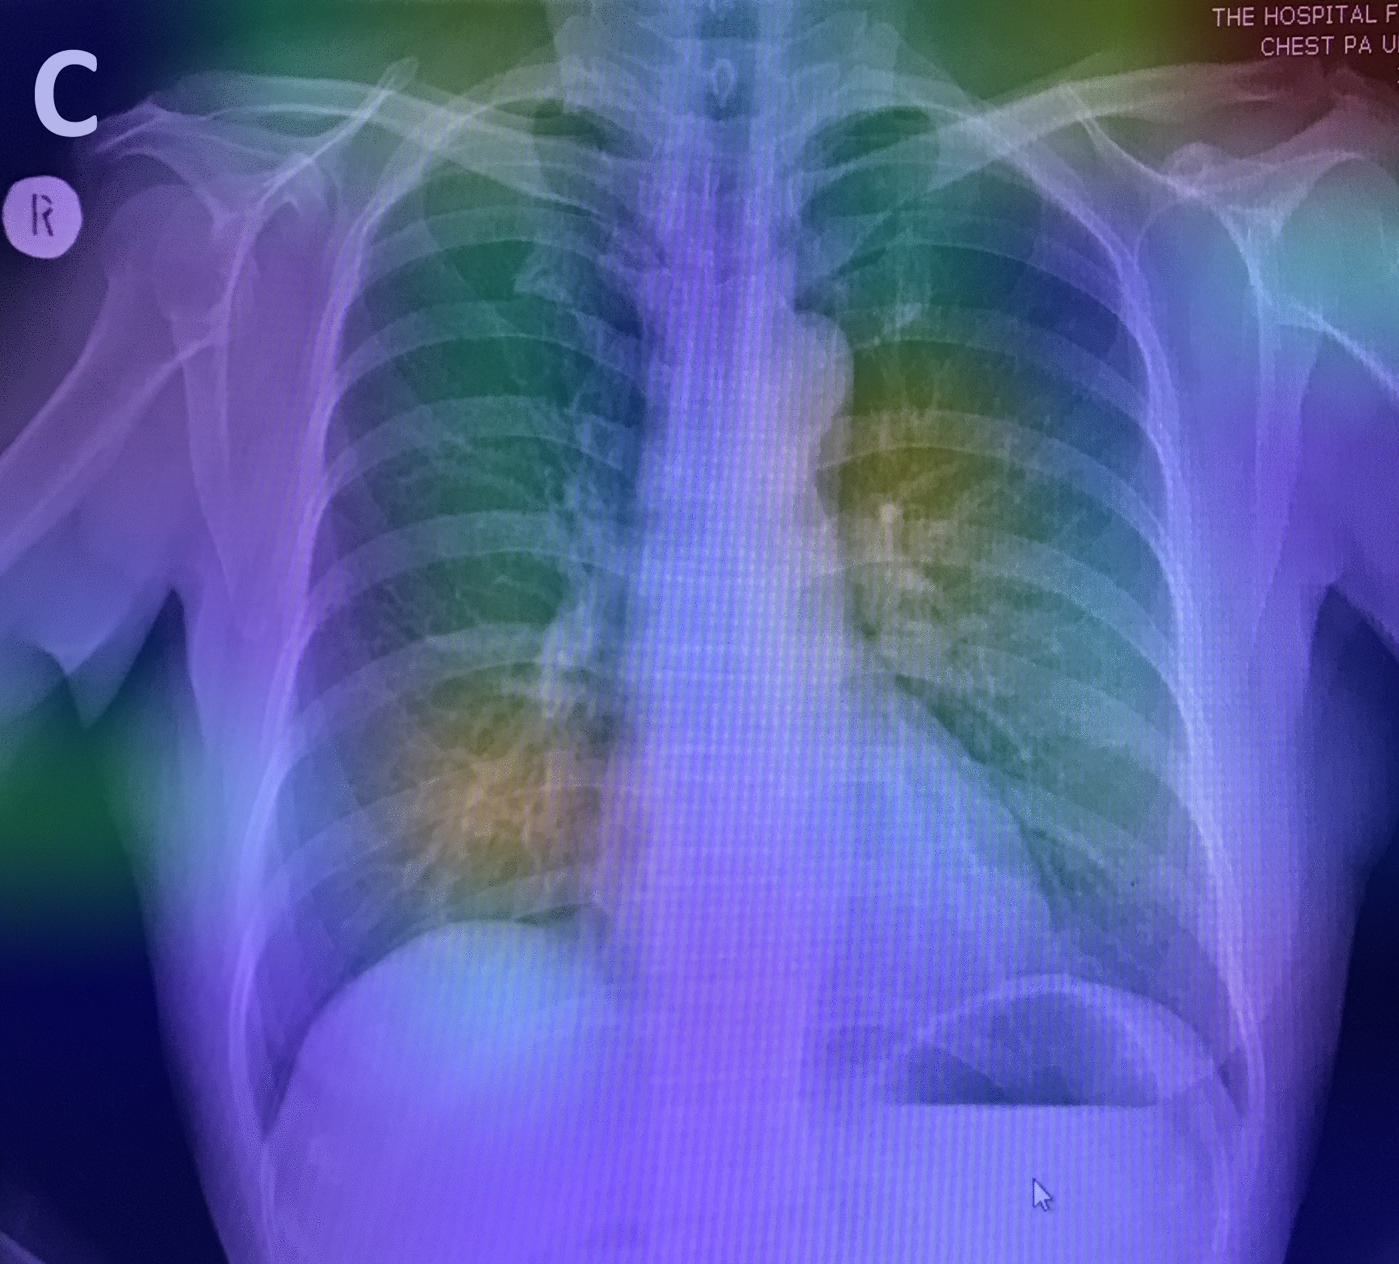

In [317]:
# Covid Grad-CAM
img_path = "../data/Chest X-Rays/val/COVID19/COVID19(572).jpg"
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)


In [274]:
# Select image

# Covid
# img_path = "./data/Chest X-Rays/val/COVID19/COVID19(570).jpg" # Covid Image


# Normal
# img_path = "./data/Chest X-Rays/test/NORMAL/IM-0041-0001.jpeg"

# Pneumonia
# img_path = "./data/Chest X-Rays/val/PNEUMONIA/person1951_bacteria_4882.jpeg"
# TB
# img_path = "./data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-658.png"
img_path = "../data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-3.png"

### Covid19

Let's preview an activation heatmap in its base form before it is applied to the image and upscaled.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted: COVID19


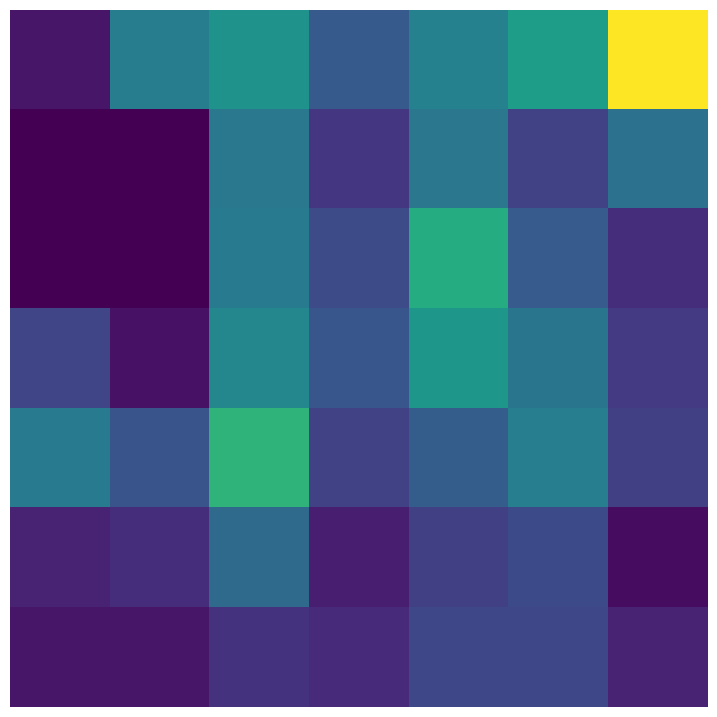

In [278]:
# Covid Grad-CAM activation heatmap

# Covid image
# img_path = "./data/Chest X-Rays/val/COVID19/COVID19(570).jpg"
# img_path = "./data/Chest X-Rays/val/COVID19/COVID19(571).jpg"
img_path = "../data/Chest X-Rays/val/COVID19/COVID19(572).jpg"

display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path, 1)

And now let's apply that heatmap to the image it corresponds to.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: COVID19


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


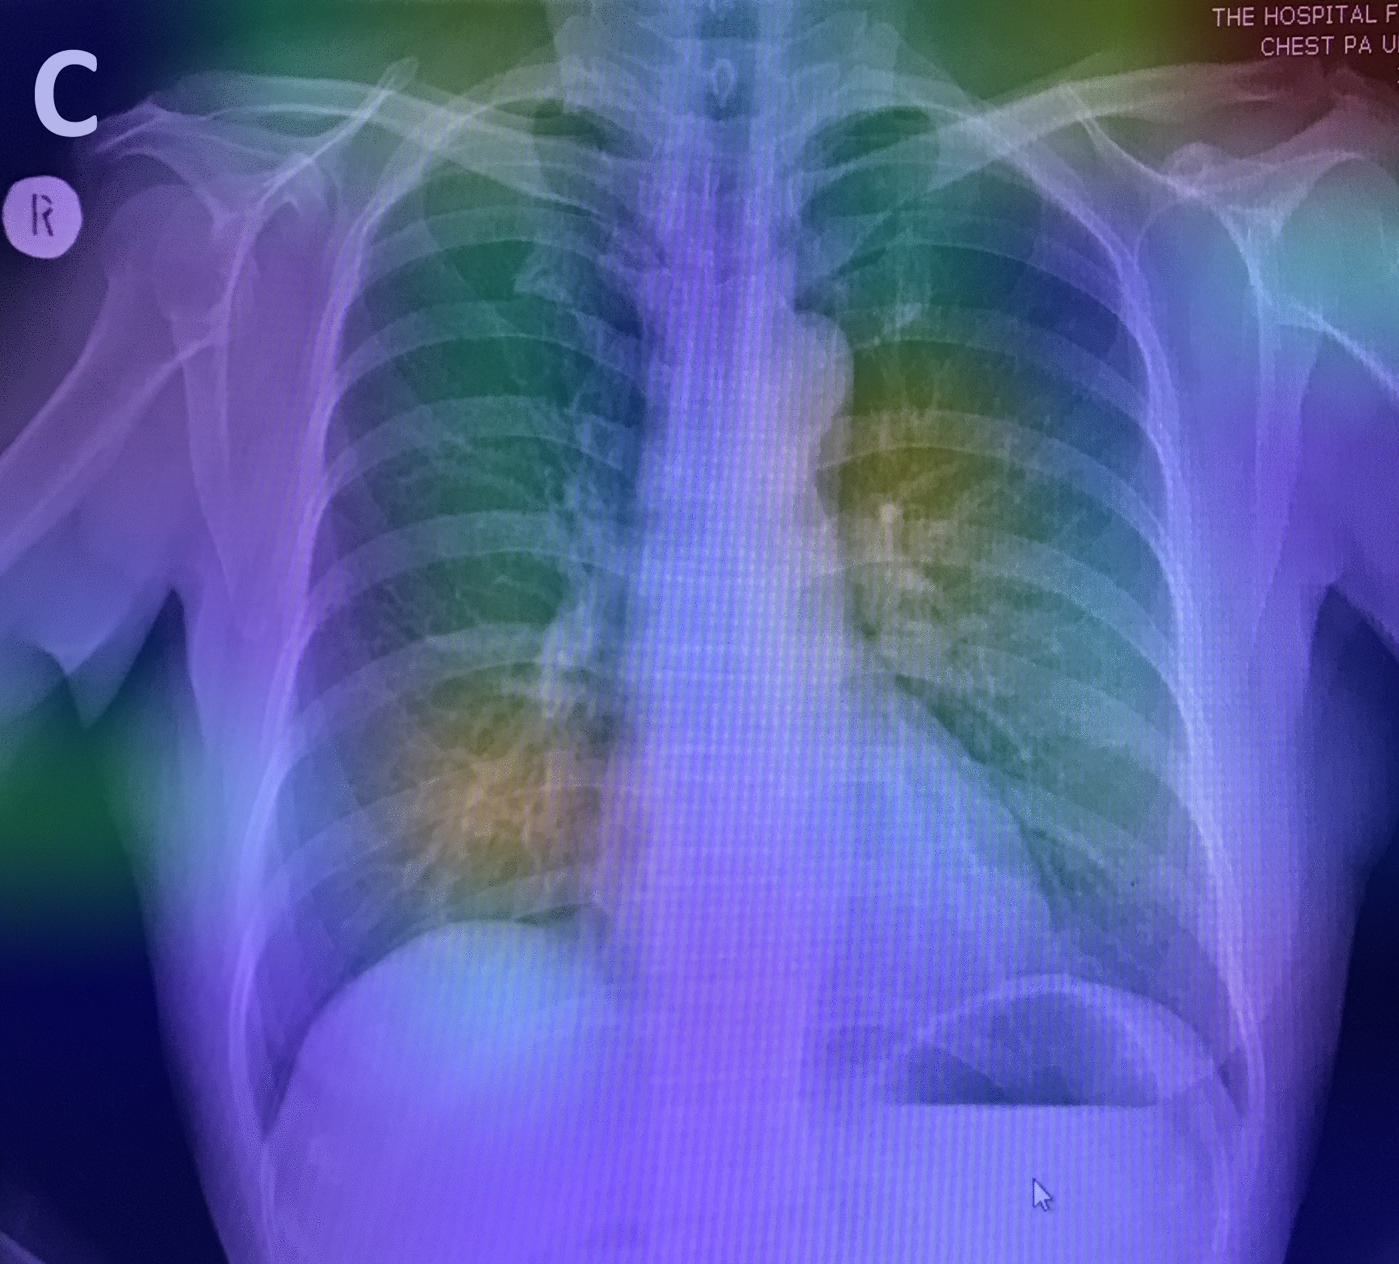

In [281]:
# Covid Grad-CAM
img_path = "../data/Chest X-Rays/val/COVID19/COVID19(572).jpg"
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

For this image the activations seem to be strong in a couple of spots in the lungs but what is worrying is the strong activation around the person's shoulders or maybe the background itself.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: COVID19


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


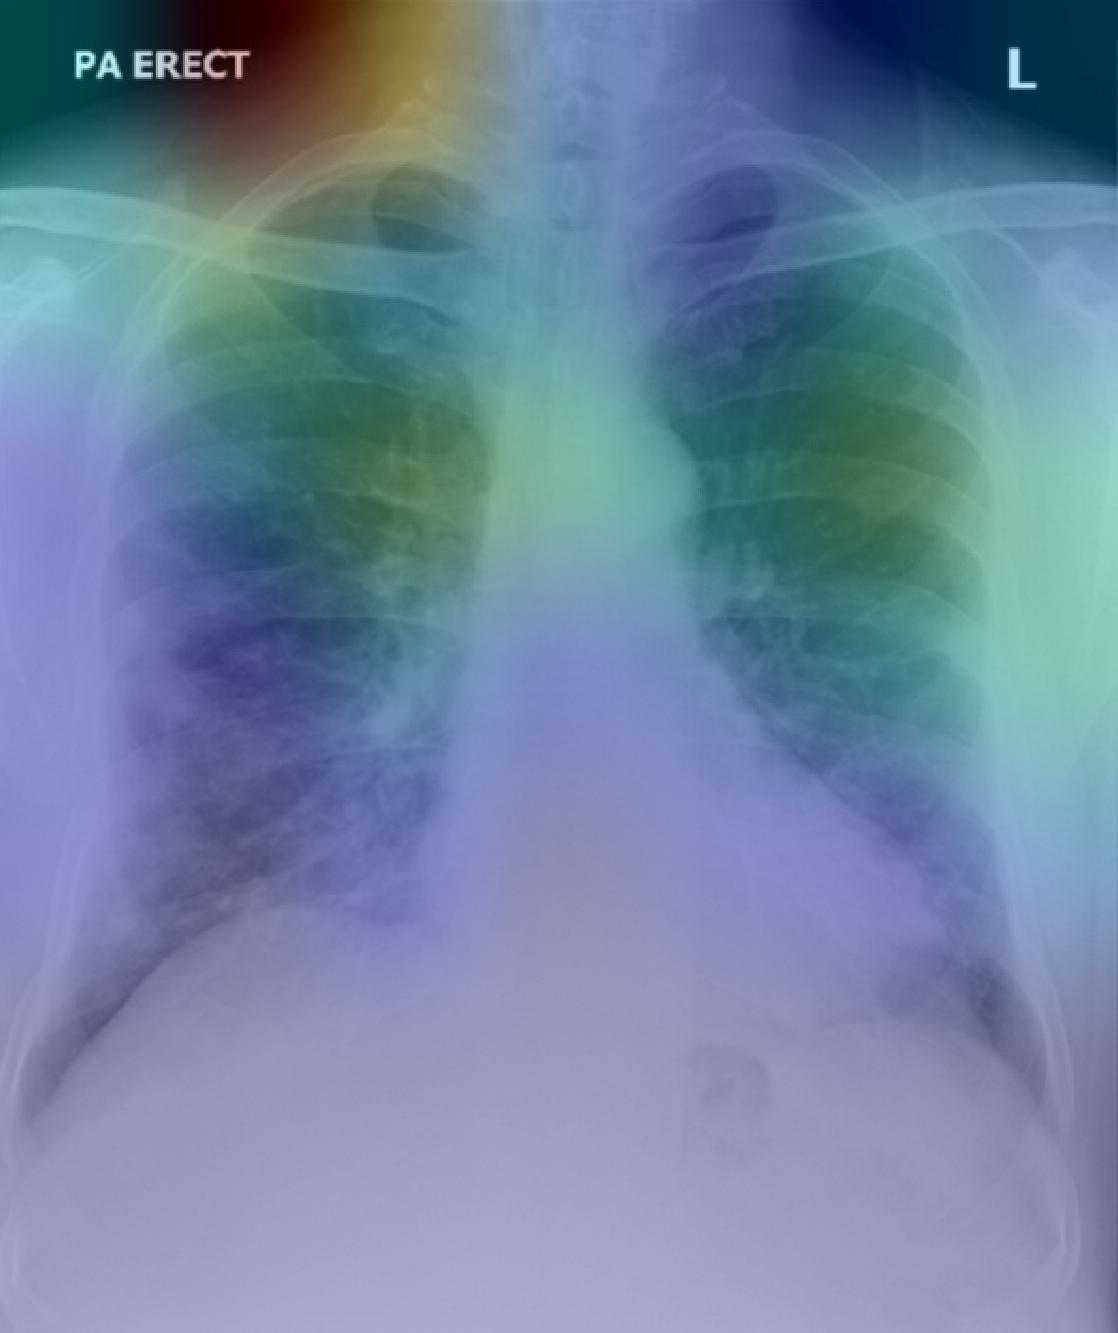

In [284]:
# Covid Grad-CAM
img_path = "../data/Chest X-Rays/val/COVID19/COVID19(566).jpg"
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

This one is looking much better with activation tageting the lungs almost exclusively. There is again a bit of activation towards the shoulders which I do not like. I do know that he dataset does not contain data for that many patients.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: PNEUMONIA


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


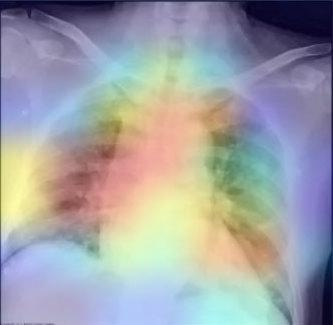

In [286]:
img_path = "../data/Chest X-Rays/val/COVID19/COVID19(573).jpg" # Covid - all over the place
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

This one however seems to be all over the place. There is a strong activation on the left side of the lungs but also the shoulders of the person once again.

### Normal

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: NORMAL


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


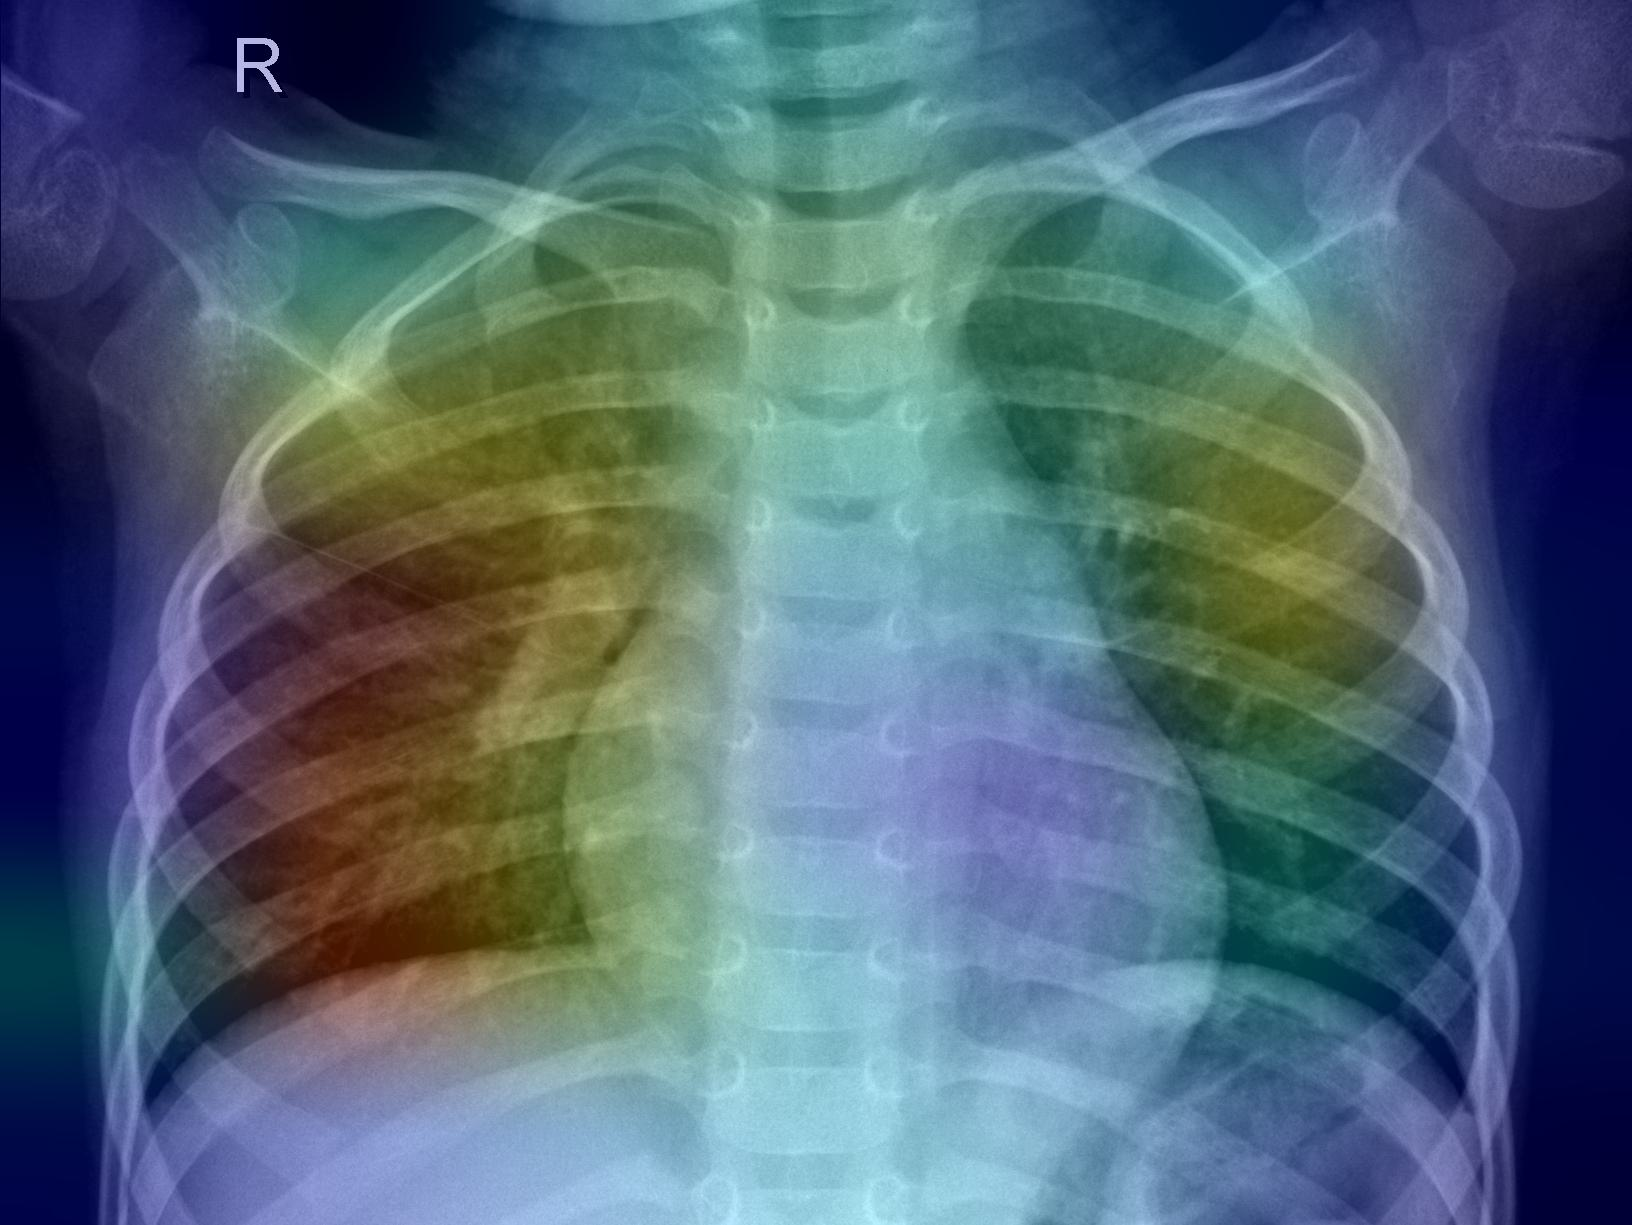

In [290]:
# Normal Grad-CAM

# img_path = "./data/Chest X-Rays/val/NORMAL/NORMAL2-IM-1430-0001.jpeg"
img_path = "../data/Chest X-Rays/val/NORMAL/NORMAL2-IM-1440-0001.jpeg"

display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

Decent activation for the normal images though the bottom left area is questionable and also the top on on the spine is not optimal either.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: NORMAL


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


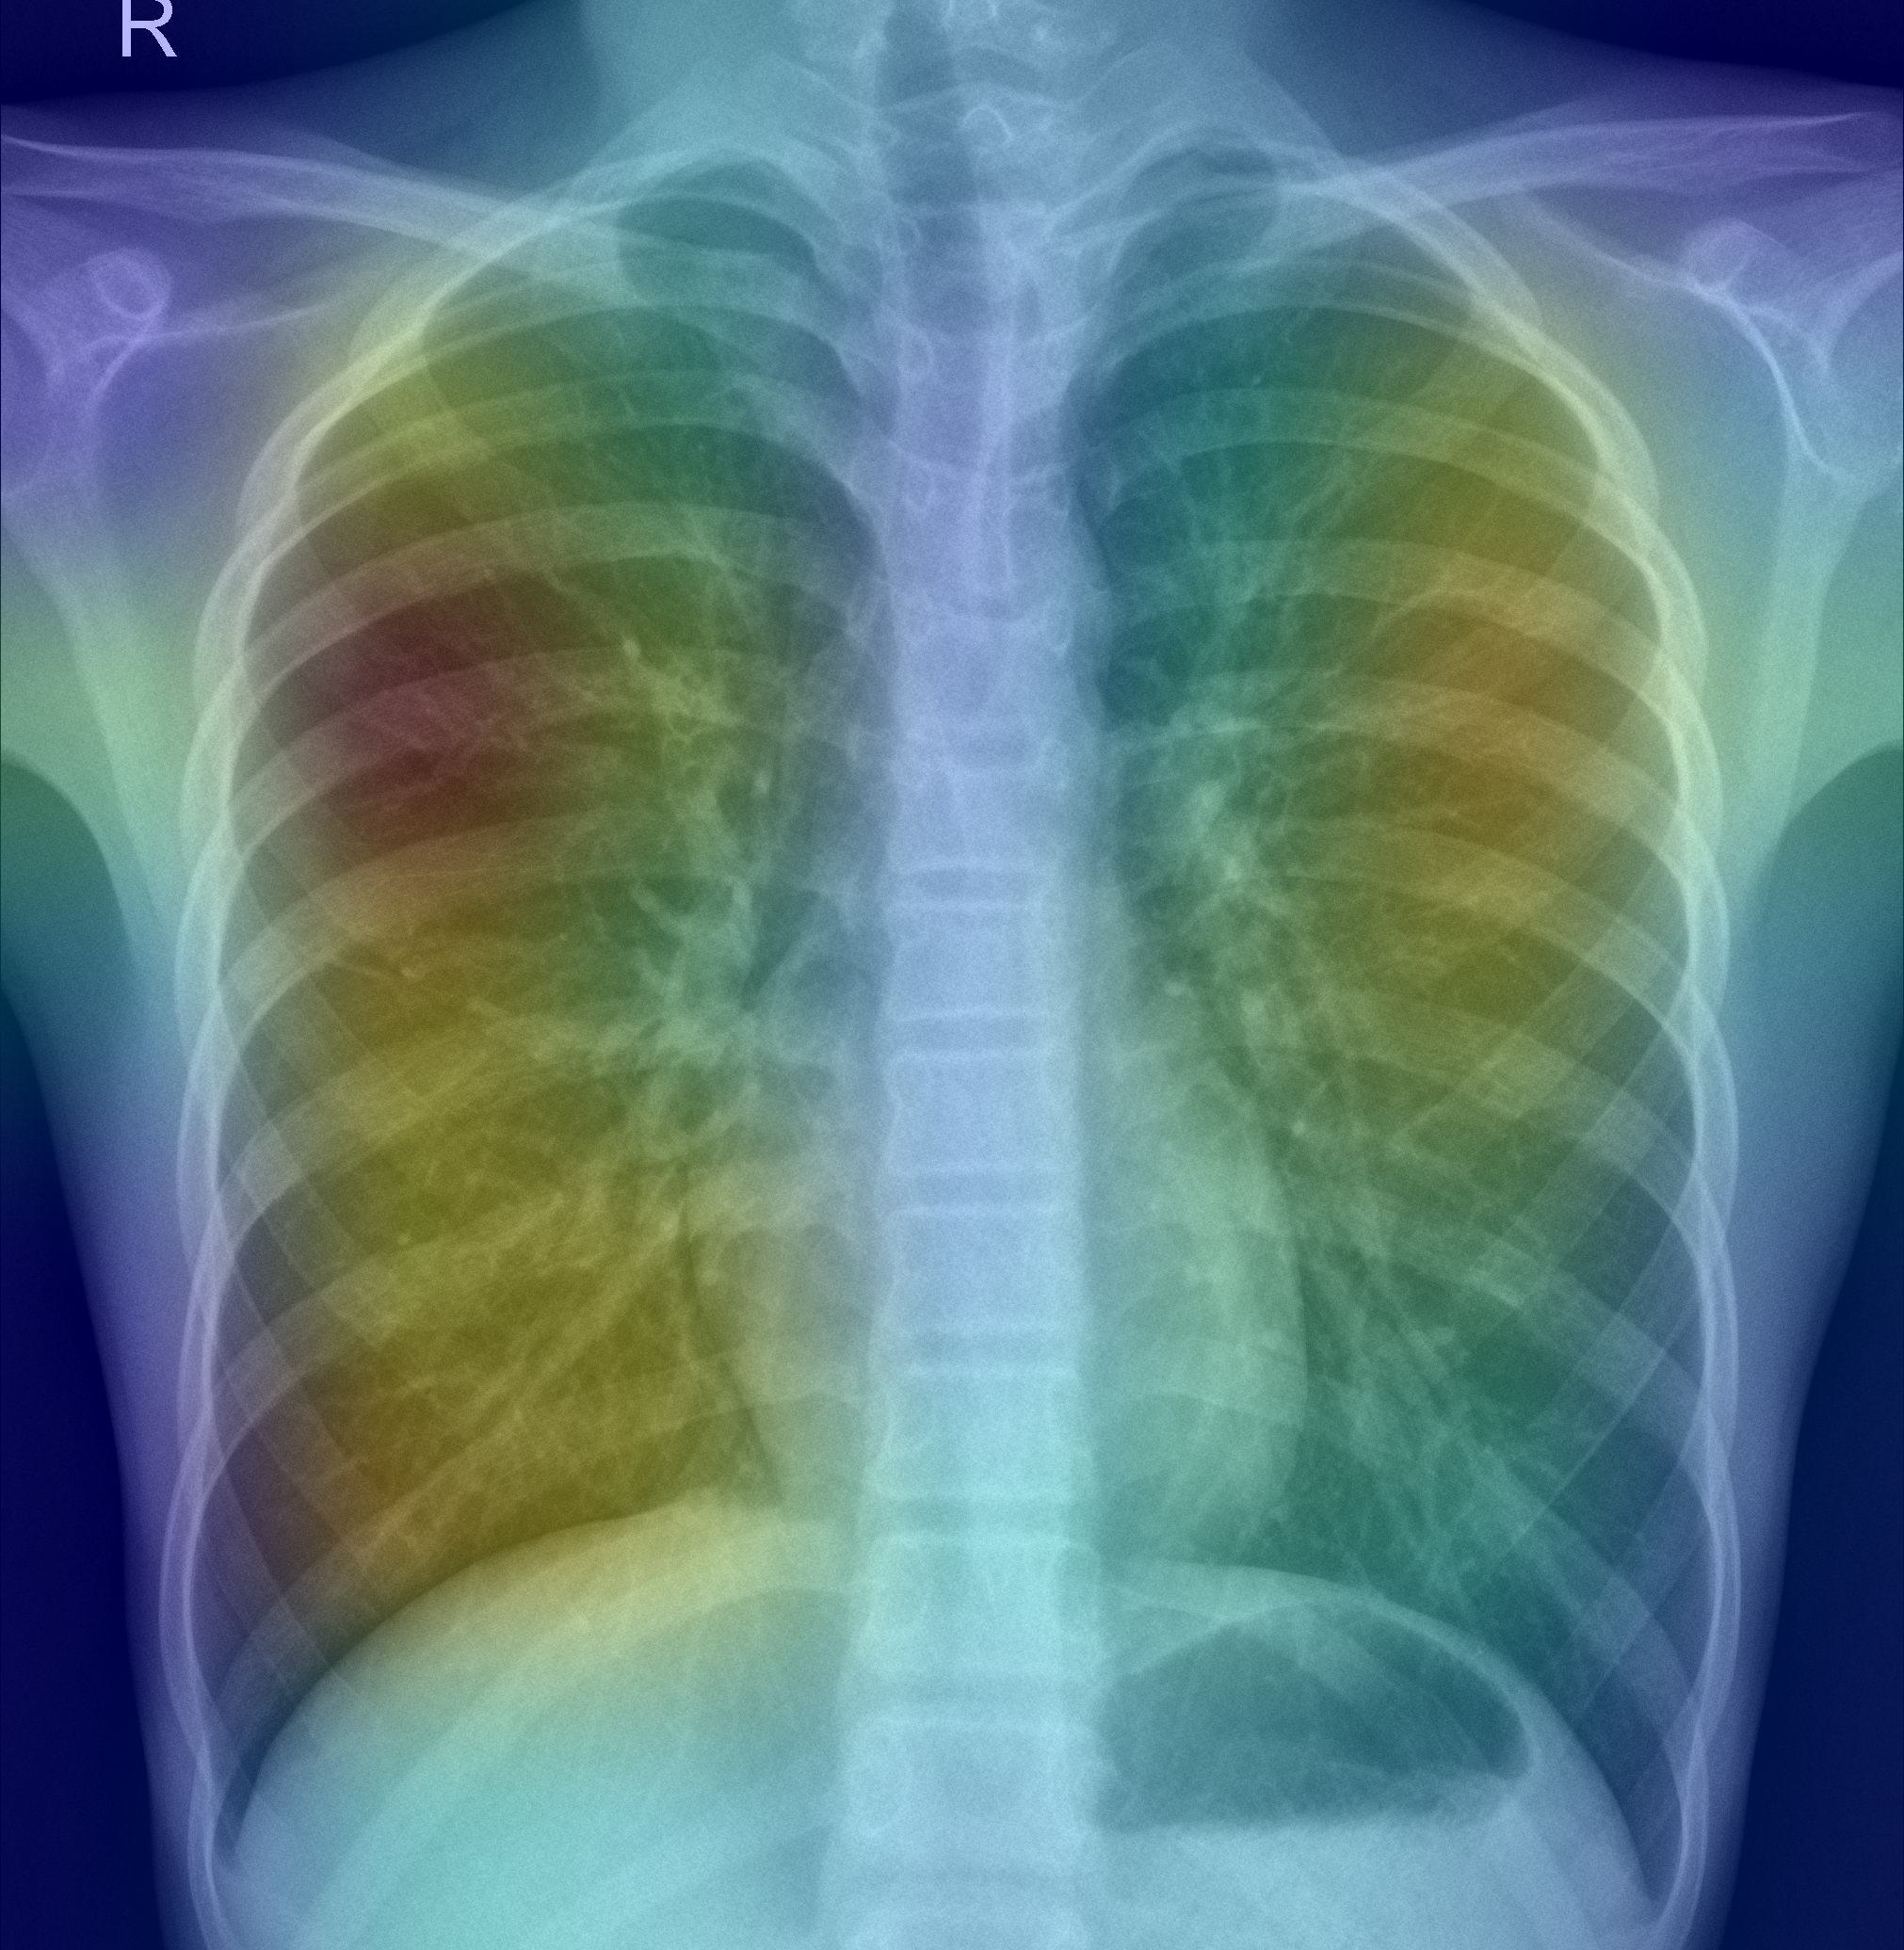

In [294]:
img_path = "../data/Chest X-Rays/test/NORMAL/IM-0041-0001.jpeg" # Normal with affinity to skeletal structure
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

Again, the activations for this image is very much focused on odd spots of the image, largly favouring the person's structure more than the lungs themselves.

### Pneumonia

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: PNEUMONIA


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


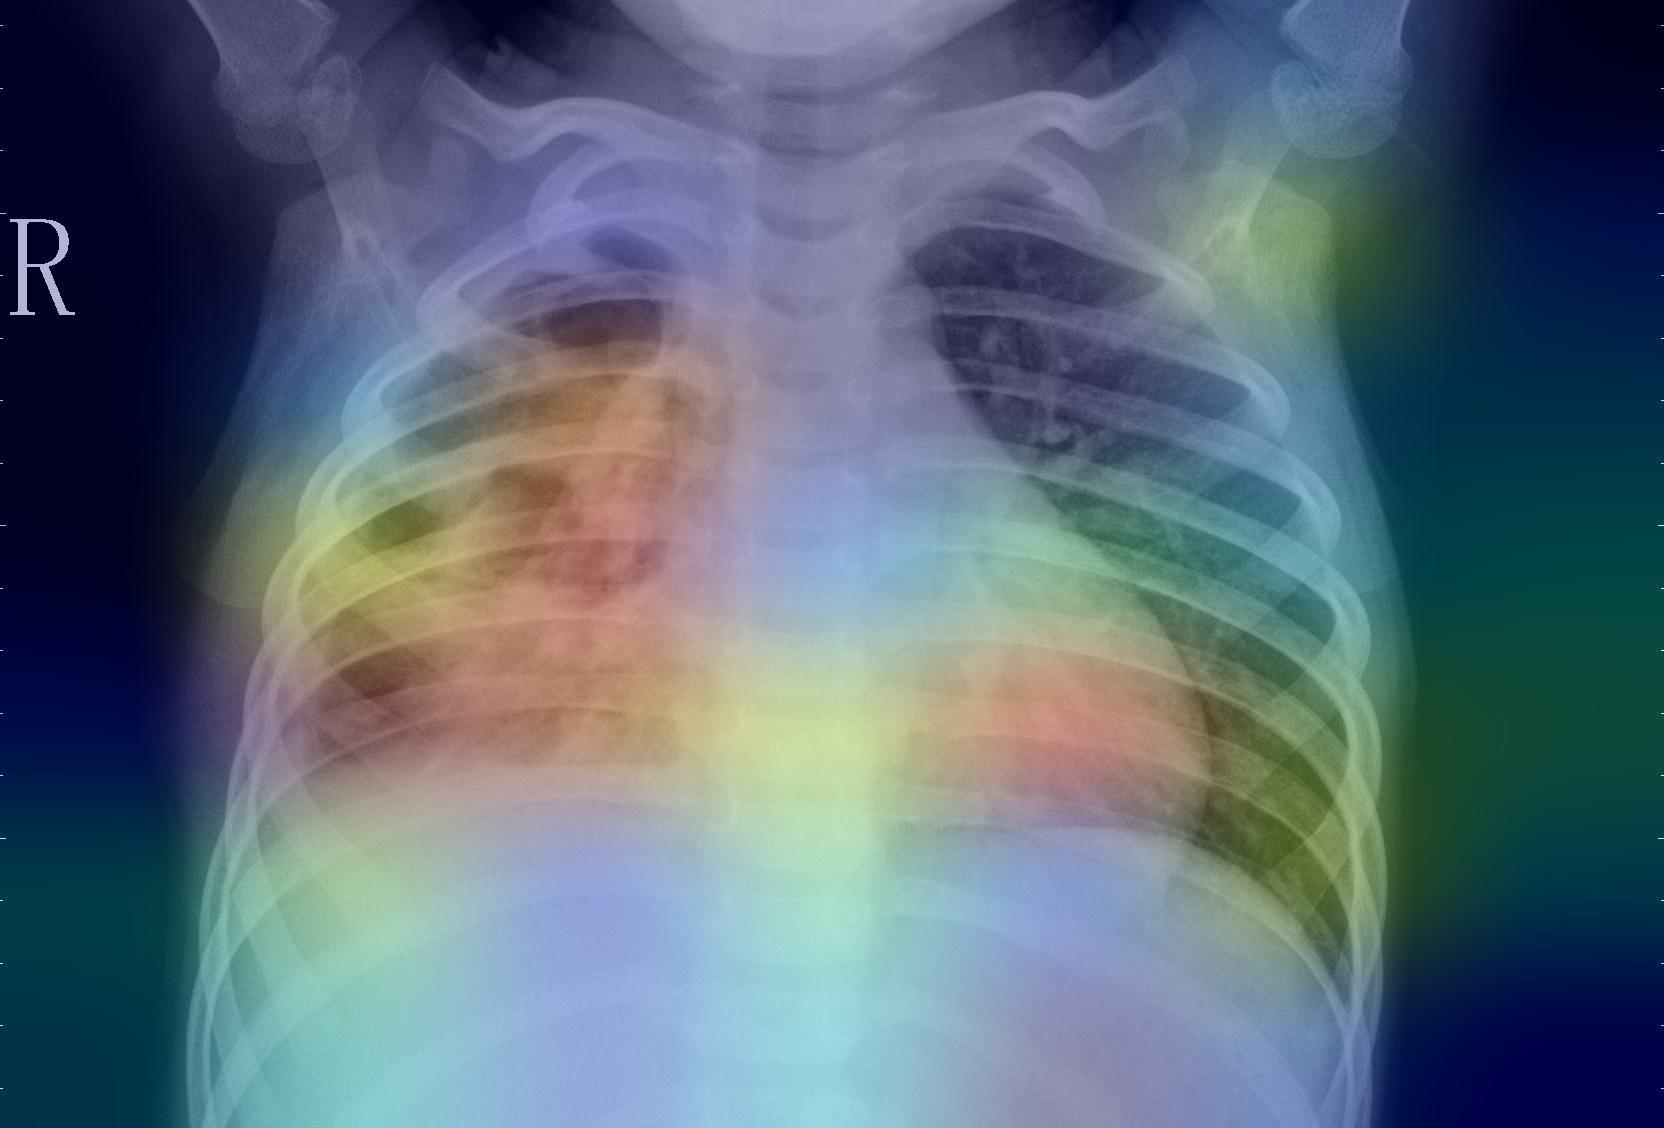

In [297]:
# Pneumonia Grad-CAM

# img_path = "./data/Chest X-Rays/val/PNEUMONIA/person1951_bacteria_4882.jpeg"
img_path = "../data/Chest X-Rays/val/PNEUMONIA/person1954_bacteria_4886.jpeg"
# img_path = "./data/Chest X-Rays/val/PNEUMONIA/person1949_bacteria_4880.jpeg"
display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

Some doing knowledge on my part would come in handy at this point. From what I can tell the pneumonia activations are all that bad.

### Turberculosis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: TURBERCULOSIS


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


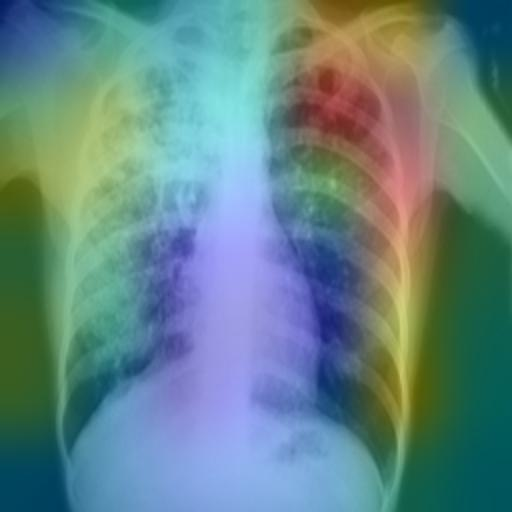

In [301]:
# Turberculosis Grad-CAM

# img_path = "./data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-3.png"
# img_path = "./data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-652.png"
img_path = "../data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-659.png"

display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

The TB activations don't look good at all as the model seems to be favouring the background more than anything else.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: TURBERCULOSIS


C:\Users\ksbon\AppData\Local\Temp\ipykernel_8872\3899838659.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


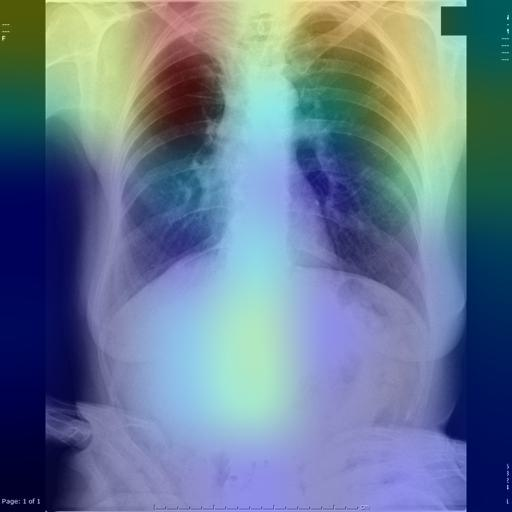

In [304]:
img_path = "../data/Chest X-Rays/val/TURBERCULOSIS/Tuberculosis-652.png"

display_GRAD_heatmaps(MobileNet_transfer_loaded, img_path)

Despite the Covid prediction by the model, this is actually a TB image. The activations look promissing but it is predicting the wrong illness so it is an unfortunate result.

## Conclusions

Overall the moels have not performed all that well. Despite the relatively high scores it does seem that the models have just overfit the entire dataset. My analisys was focused on the MobileNet transfer learning model which performed the best but I do expect all of its issues to also apply to the rest of the models in the notebook.

The visualization analysis shows that there is a severe overfitting issue. The model was not able to deal with any of the images pulled from the internet which signifies a very strong bias towards the data it was trained on. That is most likely the result of the small dataset I had at my disposal. That being said, if the dataset was any larger I would have struggeled quite a bit with the training times on my machine.

When browsing through the dataset's folders I did notice that the images all come from a very small number of patients, 4-10 per disease I would say. That may be the reason why I was seeing such strong activations around the shoulders and spine area on some of the Grad-CAM examples as the model learned more about the patients themselves rather than the diseases.

Another downside with this task is my lack of knowledge in the domain which I have chosen. Some of the Grad-CAM visualizations seemed to be looking in the correct place but I cannot really confirm that as I myself do not know what to look for. To continue with this research I either need help from a trained medical specialist or I need to do a bit more research on the topic.

Given a significant increase in the data, I do believe that this approach can work. The use of a different loss function can also be very benefitial. Categorical crossentropy is known to stuggle with imbalanced classification and there is even some research done on imbalanced xray calssification as shown in the following paper - [Multi-loss ensemble deep learning for chest X-ray classification](https://arxiv.org/ftp/arxiv/papers/2109/2109.14433.pdf). This paper's finding state that their ensamble approach achieves the best results but a very close second is the Focal Tversky loss. I tried to implement it using code from Kaggle's loss function library but was unfortunately unable to get it running. The Focal Tversky loss would have improved penalties for misclassifications which was the main issue during model training (if we disregard the overfitting issues of course).

## References

* [Tensorflow](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)
* [Kaggle - Chest X-Ray (Pneumonia,Covid-19,Tuberculosis)](https://www.kaggle.com/jtiptj/chest-xray-pneumoniacovid19tuberculosis)
* [Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
* [Classification of COVID-19 chest X-Ray and CT images using a type of dynamic CNN modification method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8081579/#fn1)
* [Multi-loss ensemble deep learning for chest X-ray classification](https://arxiv.org/ftp/arxiv/papers/2109/2109.14433.pdf)
* [Automated abnormality classification of chest radiographs using deep convolutional neural networks](https://www.nature.com/articles/s41746-020-0273-z)
* [Searching for MobileNetV3](https://arxiv.org/pdf/1905.02244.pdf)
* [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391v4.pdf)
* [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)